This notebook generates a series of LTL formula and associated traces from the resultant automaton DAG.

*NOTE*  

This notebook requires Python 3.10 or later to run.


In [1]:
import random
import sys 
import re
import dataclasses
import copy 

import spot
import spot.gen as sg

import ply.lex as lex
import ply.yacc as yacc

import ipywidgets as widgets

import pandas as pd

from pathlib import Path

from graphviz import Digraph
from graphviz import Graph
from graphviz import Source   # Used to read existing dot files

from IPython.display import HTML, display

spot.setup(size='12,8')

In [2]:
class bcolors:
    LTGRAY  = '\033[97m'
    CYAN    = '\033[96m'
    MAGENTA = '\033[95m'
    BLUE    = '\033[94m'
    ORANGE  = '\033[93m'
    GREEN   = '\033[92m'
    RED     = '\033[91m'
    GREY    = '\033[90m'
    ENDC    = '\033[0m'
    BOLD    = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:

dLineSeparator = f'='*40
lineSeparator = f'-'*40


---
### The Lexer

See the docs at:   
https://ply.readthedocs.io/_/downloads/en/latest/pdf/


In [4]:
class DotLexer(object):
    reserved = {
                'digraph'     : 'DIGRAPH',
                'node'        : 'NODESTYLE',
                'edge'        : 'EDGESTYLE',
                'labelloc'    : 'LABELLOC',
                'rankdir'     : 'RANKDIR',
                'fontname'    : 'FONTNAME',
                'size'        : 'SIZE',
                'width'       : 'WIDTH',
                'height'      : 'HEIGHT',
                'label'       : 'LABEL',
                'shape'       : 'SHAPE',
                'style'       : 'STYLE',
                'fillcolor'   : 'FILLCOLOR',
                'arrowhead'   : 'ARROWHEAD',
                'arrowsize'   : 'ARROWSIZE',
                'peripheries' : 'PERIPHERIES',
                'I'           : 'INITIALSTATE',
                'tooltip'     : 'TOOLTIP',
               }
    
    literals = ['(',')','<','>','[',']','=',',','{','}']
        
    tokens = [ 
                'STRING',
                'HTMLSTRING',
                'ID',
                'CONNECTOR',
                'NUMBER',
                'NOT',
                'AND',
                'OR',
              ]  + list(reserved.values())
    
    t_NOT       = r'!'
    t_AND       = r'&amp;'
    t_OR        = r'\|'
    t_CONNECTOR = r'->'
    t_NUMBER    = r'(\.|[0-9])[0-9]*'
    
    #A string containing ignored characters (spaces and tabs)
    t_ignore  = ' \t\n\r'
    
    def __init__(self):
        # Build the lexer
        self.lexer = lex.lex(module=self,debug=0,reflags=re.UNICODE | re.VERBOSE)
    
    # def t_INF(t):
    #     r'(<(inf|Inf).*>)|(<\[Büchi\]>)|(<font.*font>)'
    #     t.value = t.value
    #     return t
        
    def t_HTMLSTRING(self,t):
        r'(<br\/>|(<(inf|Inf).*>)|(<\[Büchi\]>)|(<\/?font[^>]*>)|<([a-zA-Z][a-zA-Z0-9]*)\b[^>]*>.*?</\3>)'
    #    r'<([a-zA-Z][a-zA-Z0-9]*)\b[^>]*>.*?</\2>'
        t.value = t.value
        return t
        
    def t_ID(self,t):
        r'[a-zA-Z\u0080-\u3000/][a-zA-Z0-9\.\u0080-\u3000/]*'
        t.type = self.reserved.get(t.value,'ID')    # Check for reserved words
        return t
        
    def t_STRING(self,t):
        r'".*"'
        t.value = t.value
        return t
        
    # # Error handling rule
    def t_error(self,t):
        print("Illegal character '%s'" % t.value[0])
        print(t.value[0].encode('raw_unicode_escape'))
        t.lexer.skip(1)

    def build(self,**kwargs):
        self.lexer = lex.lex(module=self, **kwargs)

    # Test it output
    def test(self,data):
        self.lexer.input(data)
        while True:
             tok = self.lexer.token()
             if not tok:
                 break
             print(tok)


----

### The Parser

In [5]:
class DotParser(object):

    tokens = DotLexer.tokens
    literals = DotLexer.literals
    reserved= DotLexer.reserved
    
    precedence = (
        ('left', 'AND', 'OR'),
        ('left', 'NOT'),
    )

    def __init__(self):
        self.lexer = DotLexer()
        self.parser = yacc.yacc(module=self,write_tables=False)

    def parse(self,formula,auto):
        self.auto = auto
        self.parser.parse(formula.formulaDot, debug=False)
        return self.auto
        
    def p_graph(self,p):
        'graph : DIGRAPH STRING body'
        p[0] = f'{p[1]} {p[2]} {p[3]}'
    #    print(f'graph:       {p[0]}')
    
    def p_body(self,p):
        '''body : '{' statements '}' '''
        p[0] = f'{p[1]} \n{p[2]} \n{p[3]}'
    #    print(f'Body:        {p[0]}')
    
    def p_statements2(self,p):
        '''statements : statements  statement
                      | statements  style
                      '''
        p[0] = f'{p[1]} {p[2]}\n'
        # print(f'statements2: {p[0]}')
    
    def p_statements1(self,p):
        '''statements : statement'''
        p[0] = f'{p[1]}'
        # print(f'statements1: {p[0]}')
    
    def p_rankdir(self,p):
        '''statement : RANKDIR '=' ID'''
        p[0] = f'{p[1]} = {p[3]}'
    #    print(f'rankdir:     {p[0]}')
    
    def p_label(self,p):
        '''label : LABEL '=' html
                 | LABEL '=' STRING 
                 | LABEL '=' extra
                 '''
        p[0] = Label(p[1],p[3])
        # print(f'label.value: {p[0].label}: {p[0].value}, {p[3]}, {type(p[3])}')
    
    def p_extraText(self,p):
        '''extra : HTMLSTRING
                 | extra HTMLSTRING
                 '''
        if len(p) == 2:
            p[0] = f'{p[1]}'
        else:
            p[0] = f'{p[1]} {p[2]}'
        # print(f'Extra: {p[0]}')
            
    def p_nodeStyle(self,p):
        '''statement : NODESTYLE '[' style ']' '''
        p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
        # print(f'node style:  {p[0]} {type(p[3])}')
    
    def p_edgeStyle(self,p):
        '''statement : EDGESTYLE '[' style ']' '''
        p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
    #    print(f'edge style:  {p[0]}')
    
    def p_node(self,p):
        '''statement : NUMBER '[' style ']' 
                     | ID '[' style ']' 
                     | INITIALSTATE '[' style ']' '''
    #    p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
        self.auto.addState(p[1],p[3])
        # print(f'node:  {p[1]} | {p[3]}')
    
    def p_nodeConnect(self,p):
        '''statement : INITIALSTATE CONNECTOR NUMBER 
                     | INITIALSTATE CONNECTOR NUMBER '[' style ']'
                     | NUMBER CONNECTOR NUMBER 
                     | NUMBER CONNECTOR NUMBER '[' style ']' 
                     | NUMBER CONNECTOR ID 
                     | NUMBER CONNECTOR ID '[' style ']' 
                     | ID CONNECTOR NUMBER 
                     | ID CONNECTOR NUMBER '[' style ']' 
                     | ID CONNECTOR ID 
                     | ID CONNECTOR ID '[' style ']' 
                     '''
        if len(p) == 4:
            p[0] = f'{p[1]} {p[2]} {p[3]}'
            self.auto.addEdge(p[1],p[3],Label('label',Predicate('1')))
        else:
            p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]} {p[5]} {p[6]}'

            # Spot can generate some hidden nodes that have no predicates on the edge but do have styling 
            # These end up here as a style that is a string and not a label. Make a label.
            if isinstance(p[5], str) == True:
                pred = Predicate('1')
                p[5] = Label('Label',pred)
                
            self.auto.addEdge(p[1],p[3],p[5])
            self.auto.addPredicate(p[5].value.predicates())
        # print(f'nodeConnect:  {p[0]}')
    
    def p_style(self,p):
        '''style : style ','
                 | style LABELLOC    '=' STRING 
                 | style SHAPE       '=' STRING
                 | style STYLE       '=' STRING
                 | style STYLE       '=' ID
                 | style FILLCOLOR   '=' STRING
                 | style FONTNAME    '=' STRING
                 | style ARROWHEAD   '=' ID
                 | style ARROWSIZE   '=' NUMBER
                 | style WIDTH       '=' NUMBER
                 | style WIDTH       '=' STRING
                 | style HEIGHT      '=' NUMBER
                 | style HEIGHT      '=' STRING
                 | style TOOLTIP     '=' STRING
                 | style PERIPHERIES '=' NUMBER
                 | LABELLOC    '=' STRING 
                 | SHAPE       '=' STRING
                 | STYLE       '=' STRING
                 | STYLE       '=' ID
                 | FILLCOLOR   '=' STRING
                 | FONTNAME    '=' STRING
                 | ARROWHEAD   '=' ID
                 | ARROWSIZE   '=' NUMBER
                 | WIDTH       '=' NUMBER
                 | WIDTH       '=' STRING
                 | HEIGHT      '=' NUMBER
                 | HEIGHT      '=' STRING
                 | TOOLTIP     '=' STRING
                 | PERIPHERIES '=' NUMBER
                 '''
        if len(p) == 2:
            p[0] = f'{p[1]}'        
        elif len(p) == 3:
            # print(f'{bcolors.GREEN}** p[1] type: {type(p[1])} = {p[1]}, P[2] type: {type(p[2])} = {p[2]}{bcolors.ENDC}',end='')
            if type(p[1]) == Label:
                # print(f'*{p[1].value}*{type(p[1].value)}*',end='')
                if type(p[1].value) == Predicate:
                    p[1].value.value = p[1].value.value + p[2]
                    p[0] = p[1]
                    # print(f'*{p[1].value}*{type(p[1].value)}* *{p[0].value}*{type(p[0].value)}*')
                else:
                    # print()
                    p[0] = f'{p[1]} {p[2]}'
            else:
                # print()
                p[0] = f'{p[1]} {p[2]}'
        elif len(p) == 4:
            p[0] = f'{p[1]} = {p[3]}'
        else:
            # print(f'{bcolors.GREEN}** p[1] type: {type(p[1])} = {p[1]}, P[2] type: {type(p[2])} = {p[2]}{bcolors.ENDC}',end='')
            if type(p[1]) == Label:
                # print(f'*{p[1].value}*{type(p[1].value)}*',end='')
                if type(p[1].value) == Predicate:
                    p[1].value.value = p[1].value.value + f'{p[2]} = {p[4]}'
                    p[0] = p[1]
                    # print(f'*{p[1].value}*{type(p[1].value)}* *{p[0].value}*{type(p[0].value)}*')
                else:
                    # print()
                    p[0] = f'{p[1]} {p[2]} = {p[4]}'
            else:
                # print()
                p[0] = f'{p[1]} {p[2]} = {p[4]}'
        # print(f'style:       {p[0]}, {bcolors.BLUE}{type(p[0])}{bcolors.ENDC} {len(p)}')
    
    def p_styleLabel(self,p):
        '''style : label
                 | style label
                 '''
        if len(p) == 2:
            p[0] = p[1]
        elif len(p) == 3:
            p[1].addLabel(p[2])
            p[0] = p[1]
        # print(f'styleLabel:  {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC} len(p): {len(p)}')
       
    def p_html(self,p):
        '''html : '<' htmlbody '>'
                '''
        p[0] = p[2]
        # p[0] = f'{p[1]} {p[2]} {p[3]}'
        # print(f'html:         {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC}')
    
    def p_htmlbody(self,p):
        '''htmlbody : STRING
                    | equation
                    | htmlbody equation  
                    | htmlbody '(' HTMLSTRING ')'
                    '''

        if len(p) == 2:
            p[0] = p[1]
        elif len(p) == 3:
            print(f'hb2 {p[1]} {p[2]}')
            p[1].addLabel(p[2])
            p[0] = p[1]
        else:
            print(f'hb3 {p[1]} {type(p[1])} {p[3]} {type(p[3])} ')
            p[1].addLabel(p[3])
            p[0] = p[1]
            
        # print(f'htmlbody:     {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC} len(p): {len(p)}')
    
    def p_equation_id(self,p):
        ''' equation : equation term
                     '''
        p[1].addLabel(p[2])
        p[0] = p[1]
        # print(f'html id:    {p[0]} {type(p[0])} {p[1]} {type(p[1])} {p[2]} {p[1].label}')
    
    def p_equation_eq(self,p):
        ''' equation : equation '(' equation ')'
                     | equation '[' equation ']'
                     '''
        p[1].addLabel(p[3])
        p[0] = p[1]
        # print(f'equation eq:    {p[0]} {type(p[0])}')
    
    def p_equation_html(self,p):
        ''' equation : equation HTMLSTRING
                     '''
        p[0] = p[1]
        # print(f'html equation:    {p[0]} {type(p[0])} {p[1]} {type(p[1])}')
    
    def p_equation_binary_and(self,p):
        ''' equation : equation AND equation
                     '''
        p[0] = AndNode(p[1],p[3])
        # print(f'EQ And:   {p[0]} {type(p[0])}')
    
    def p_equation_binary_or(self,p):
        ''' equation : equation OR equation
                     '''
        p[0] = OrNode(p[1],p[3])
        # print(f'EQ Or:    {p[0]} {type(p[0])}')
    
    def p_equation_term(self,p):
        ''' equation : term
                     '''
        p[0] = p[1]
        # print(f'EQ term:  {p[0]} {type(p[0])}')
        
    def p_equation_unary(self,p):
        ''' equation : NOT equation
                     '''
        p[0] = UniNode(p[1],p[2])
        # print(f'EQ Uni:   {p[0]} {type(p[0])}')
    
    def p_equation_sub(self,p): 
        ''' term : '(' equation ')'
        '''
        p[0] = p[2]
        # print(f'EQ Sub:  {p[0]} {type(p[0])}')
        
    def p_equation_predicate(self,p):
        ''' term : NUMBER
                 | ID
                 '''
        p[0] = Predicate(p[1])
        # print(f'EQ Pred: {p[0]} {type(p[0])}')
        
    def p_graphsize(self,p):
        '''statement : SIZE '=' STRING '''
        p[0] = f'{p[1]} = {p[3]}'
    #    print(f'graphsize:   {p[0]}')
    
    # Error rule for syntax errors
    def p_error(self,p):
        print("Syntax error in input!")
        print(f'{p}')


In [6]:
__file__ = "DC_Parser.ipynb"

# Build the lexer
#lexer = lex.lex(debug=0,reflags=re.UNICODE | re.VERBOSE)

----
#### Code for testing just the parser

In [7]:
# Give the lexer some input
#lexer.input(graph)

# Tokenize
#for tok in lexer:
#    print(f'{tok.type:15} {tok.value:<6} {tok.lineno:3} {tok.lexpos:3} {tok}')

----
### LTL Tracegen

What follows is all the support code for building an automaton from an equation. The basic flow of the code is as follows:

* Provide an equation. It may be given directly or randomly generated by Spot.
* Spot is used to convert the equation into a Buchi automaton in dot format.
* The dot graph is parsed into an new automaton.
* Randomly walk the automaton and capture the predicate states on the edges taken.

In [8]:
def getSeed(rndSeed=False,printSeed=False):
#    seed = 96996 # generates a long diagram with multiple buchi labels
    seed = 79398 # generates a medium diagram with a graph label containing an & - not accounted for in yacc syntax
#    seed = 64165 # generates a graph title with brackets and html
    
    if rndSeed == True:
        seed = random.randrange(100000)

    if printSeed == True:
        print(f'Seed Used: {seed}')

    return(seed)

In [9]:
class DotGraph:
    def __init__(self):
        self.dot = Digraph(comment='Digraph generated by LTL_TraceGen_Spot',graph_attr=dict(rankdir='LR'))
        self.dot.attr('node',shape='circle',fontname="Helvetica")
        self.dot.attr('edge',fontname='Helvetica')


    def addState(self,state,accepting=False,color='black',fontcolor='black'):
        if state in ['Init','init','I']:
            self.dot.node(state,style='invis',shape='plaintext',width='0')
        else:
            if accepting == True:
                shape = 'doublecircle'
            else:
                shape = 'circle'
            self.dot.node(state,shape=shape,color=color,fontcolor=fontcolor)

    def addEdge(self,fromState,toState,label="",color='black',fontcolor='black'):
        if fromState in ['Init','init','I']:
            self.dot.edge(fromState,toState,'',color=color,fontcolor=fontcolor)
        else:
            self.dot.edge(fromState,toState,label,color=color,fontcolor=fontcolor)

    def addTitle(self,title):
        pass
        
    def showGraph(self,graphPrint,graphSource,graphFile):
    
        if graphSource == True:
            print(self.dot)
    
        if graphPrint == True:
            display(self.dot)
    
        if graphFile['save'] == True:
            self.dot.render(graphFile['name'], format=graphFile['format'])
        

----
#### Node Classes

The following classes are to create an binary tree of an equation


In [10]:
class Node:

    label = ''

    def addLabel(self,label):
        self.label = f'{self.label} {label}'
        return

    def trace(self):
        pass

    def evaluate(self):
        pass

    def satisfiers(self):
        pass

    def clearState(self):
        pass

class BinNode(Node):
    def __init__(self,op,childL=None, childR=None):
        self.op = op
        self.childL = childL
        self.childR = childR
        self.stateL : (Bool, None) = None
        self.stateR : (Bool, None) = None

    def predicates(self):
        return list(set(self.childL.predicates() + self.childR.predicates()))

    def satisfiers(self):
        return self.childL.satisfiers() + self.childR.satisfiers()    

    def clearState(self):
        self.stateL = None
        self.stateR = None

        self.childL.clearState()
        self.childR.clearState()

    def __repr__(self):
        return f'({self.childL} {self.op} {self.childR})'

class AndNode(BinNode):
    def __init__(self,childL=None, childR=None):
        super().__init__('&',childL,childR)

    def trace(self):
        return self.childL.trace() + self.childR.trace()

    def evaluate(self,step):
        if self.stateL == None:
            self.stateL = self.childL.evaluate(step)

        if self.stateR == None:
            self.stateR = self.childR.evaluate(step)

        if (self.stateL != None) and (self.stateR != None):
            state = self.stateL & self.stateR
        else:
            state = None
            
#        print(f'AND {step} {self.stateL} & {self.stateR} {state}')
        return state

    def satisfiers(self):
        satisfiers = []
        for lSat in self.childL.satisfiers():
            for rSat in self.childR.satisfiers():
                satisfiers.append(lSat + rSat)
#                print(f'Left: {self.childL.satisfiers()} lSat: {lSat} Right: {self.childR.satisfiers()} rSat: {rSat} | {satisfiers}')
                
        return satisfiers     
        
class OrNode(BinNode):
    def __init__(self,childL=None, childR=None):
        super().__init__('|',childL,childR)

    def trace(self):
        if random.randint(0,1) == 0:
            return (self.childL.trace())
        else:
            return (self.childR.trace())

    def evaluate(self,step):
        if self.stateL == None:
            self.stateL = self.childL.evaluate(step)

        if self.stateR == None:
            self.stateR = self.childR.evaluate(step)

        if (self.stateL != None) and (self.stateR != None):
            state = self.stateL | self.stateR
            
        elif (self.stateR != None):
            state = self.stateR
            
        elif (self.stateL != None):
            state = self.stateL
            
        else:
            state = None
            
#        print(f'OR  {step} {self.stateL} | {self.stateR} {state}')
        return state

class UniNode(Node):
    def __init__(self,op,child=None):
        self.op = op
        self.child = child
        self.state : (Bool, None) = None

    def predicates(self):
        return self.child.predicates()

    def trace(self):
        children = []
        for child in self.child.trace():
            if child[0] == '!':
                children.append(child[1:])
            else:
                children.append(f'!{child}')
        return children

    def evaluate(self,step):
        if self.state == None:
            self.state = self.child.evaluate(step)
            if self.state != None:
                self.state = not(self.state)
#            print(f'NOT {step} {self.state}')
        return self.state

    def satisfiers(self):
#        satisfiers = []
#        for pred in self.child.satisfiers():
#            if pred[0] == '!':
#                satisfiers += [pred[1:]]
#            else:
#                satisfiers += ['!' + pred]
        
        return [['!' + self.child.satisfiers()[0][0]]]

    def clearState(self):
        self.state = None
        self.child.clearState()
        
    def __repr__(self):
        return f'{self.op}{self.child}'

class Predicate(Node):
    
    def __init__(self,value):
        self.value = value
        self.state = None

    def getValue(self):
        return self.value
        
    def predicates(self):
        return [self.value]

    def trace(self):
        return [self.value]

    def evaluate(self,step):
        if self.state == None:
            if (self.value == '1'):
                self.state = True
            elif (self.value in step):
                if step[0] == '!':
                    self.state = False
                else:
                    self.state = True
            # print(f'PRD {step} {self.value} {self.state}')
        # else:
        #     print(f'PRD {step} {self.value} X')
        return self.state

    def satisfiers(self):
        return [[self.value]]
        
    def clearState(self):
        self.state = None

    def __repr__(self):
        return f'{self.value}'
        

----
The following classes are used to create an automaton data structure of labeled Nodes and Edges  

The data structures go together as follows:

<img src="LTL TraceGenDataStruct.svg" width=”5000” align="center" /> 




In [11]:
@dataclasses.dataclass
class Step:

    fromState  : str = ''
    toState    : str = ''
    predicates : list[str] = dataclasses.field(default_factory=list)
    extraPreds : list[str] = dataclasses.field(default_factory=list) # Extra predicates are unmentioned in self.predicates)set to a value. There should never be a conflicting predicate between predicates and extraPreds.
    trap       : bool = False
        
    def __repr__(self):
        return f'{self.fromState.stateNum:3} -> {self.toState.stateNum:3}: {self.extraPreds} {self.predicates}'
        
    def __eq__(self,oStep):

        if type(oStep) != Step:
            return False
            
        if self.fromState.stateNum == oStep.fromState.stateNum and self.toState.stateNum == oStep.toState.stateNum and self.predicates == oStep.predicates:
            return True

        return False

In [12]:
@dataclasses.dataclass
class Trace:
    steps : list[Step] =  dataclasses.field(default_factory=list)
    position : int = 0
    duplicate : bool = False

    @classmethod
    def strToTrace(cls,traceStr):

        trace = Trace()
        
        stepSearch = re.compile(r"([a-z!,01]*);")
        predSearch = re.compile(r"([a-z!01]+),?")

        #extract a step
        for step in stepSearch.finditer(traceStr):
            # extract the predicates for the step
            preds = []
            for pred in predSearch.finditer(step.group(1)):
               preds.append(pred.group(1))

            trace.addStep(Step('?','?',preds,[]))

        return trace

    def addStep(self,step):
        self.steps.append(step)

    def step(self):
        for step in self.steps:
            yield step.predicates

    def start(self):
        self.position = 0
        return self.steps[self.position]

    def next(self):
        if self.position < len(self.steps):
            self.position += 1
            return self.steps[self.position-1]
        else:
            return None

    def back(self):
        if self.position > 0:
            self.position -= 1
            return self.steps[self.position]
        else:
            return None

    def __len__(self):
        return len(self.steps)

    def __eq__(self,oTrace):
        if len(self.steps) == len(oTrace):
            for s1, s2 in zip(self.steps,oTrace.steps):
                if s1 != s2:
                    return False
        else:
            return False
            
        return True

    def sink(self):
        return self.steps[-1].trap
        
    def traceAsStr(self,colorDups=False):
        str = ''
        for step in self.steps:
            str = str + ','.join(step.predicates) + ';'

        color = bcolors.RED if (self.duplicate == True) and (colorDups == True) else ''
        str = f'{color}{str}{bcolors.ENDC}'
        return str

    def stateColor(self,step,HTML=False):
        styleFrom = ''
        styleTo = ''
        
        if step.fromState.accepting == True:
            if HTML == True:
                styleFrom = f'style="background-color:DarkGreen;"'
            else:
                styleFrom = bcolors.GREEN
        elif step.fromState.trap == True:
            if HTML == True:
                styleFrom = f'style="background-color:DarkRed;"'
            else:
                styleFrom = bcolors.RED
            
        if step.toState.accepting == True:
            if HTML == True:
                styleTo = f'style="background-color:DarkGreen;"'
            else:
                styleTo = bcolors.GREEN
        elif step.toState.trap == True:
            if HTML == True:
                styleTo = f'style="background-color:DarkRed;"'
            else:
                styleTo = bcolors.RED

        return styleFrom, styleTo
        
    def print(self,verbose=0,color=False,newLine=True,title=''):
        match verbose:
            case 0:
                self.start()
                step = self.next()
                while step != None:
                    cStart = ''
                    cEnd   = ''
                    if color == True:
                        _,cStart = self.stateColor(step)
                        cEnd   = bcolors.ENDC
                    print(f'{cStart}{step.toState.stateNum:>3}{cEnd}',end='')
                    step = self.next()
                    if step != None:
                        print(f', ',end='')
                if newLine == True:
                    print('')
            case 1:
                self.start()
                step = self.next()

                print(f'S   -> S\'   Predicates\n{lineSeparator}')
                self.start()
                step = self.next()
                while step != None:
                    cStart = ''
                    cEnd   = ''
                    if color == True:
                        cStart,_ = self.stateColor(step)
                        cEnd   = bcolors.ENDC

                    print(f'{cStart}{step.fromState.stateNum:>3} -> {step.toState.stateNum:>3}{cEnd}: ',end='')
                    if len(step.extraPreds) > 0:
                        for i, pred in enumerate(step.extraPreds):
                            if i > 0:
                                print(f', ',end='')
                            print(f'{pred}',end='')
                        print(f' | ',end='')
                    for i, pred in enumerate(step.predicates):
                        if i > 0:
                            print(f', ',end='')
                        print(f'{pred}',end='')
                    print()
                    step = self.next()
            case _:
                print(f'{trace}')
                
    def printHTML(self,verbose=0,color=False,title=''):
        match verbose:
            case 0:
                self.start()
                step = self.next()
                cells = ''
                while step != None:
                    styleTo = ''
                    styleFrom = ''
                    if color == True:
                        styleFrom,styleTo = self.stateColor(step,HTML=True)
                        
                    cells += f'<td {styleTo}">{step.toState.stateNum}</td>'
                    step = self.next()
                return cells
            case 1:
                self.start()
                step = self.next()

                caption = f'<caption>{title}</caption>\n' if len(title) > 0 else ''
                head1 = '\n\t<tr ><th colspan="3"> </th><th colspan="2" style="text-align:center;">Predicates</th></tr>'
                head2 = '\n\t<tr><th>s</th><th>&#10142;</th><th>s\'</th><th style="text-align:center;">Derived</th></th><th style="text-align:center;">Given</th></tr>'
                head = ''.join(['<thead style="background-color:DodgerBlue;">',head1,head2])
                
                body = '<tbody>\n'
                
                while step != None:
                    styleTo = ''
                    styleFrom = ''
                    if color == True:
                        styleFrom,styleTo = self.stateColor(step,HTML=True)
                    row = f'\t<tr><td {styleFrom}>{step.fromState.stateNum}</td><td>&#10142;</td><td {styleTo}>{step.toState.stateNum}</td>'
                
                    preds = ''
                    for i, pred in enumerate(step.extraPreds):
                        if i > 0:
                            preds += ', '
                        preds += pred
                    row += f'<td style="text-align:center;">{preds}</td>'
                
                    preds = ''
                    for i, pred in enumerate(step.predicates):
                        if i > 0:
                            preds += ', '
                        preds += pred
                    row += f'<td style="text-align:center;">{preds}</td>'
                
                    row += '</tr>\n'
                    body += row
                    step = self.next()
                
                body += '</tbody>\n'
                head += '\n</thead>\n'
                table = ''.join(['<table style="border:2px solid DodgerBlue;">\n',caption,head,body,'</table>'])
                display(HTML(table))
            case _:
                print(f'{trace}')

    def __repr__(self):
        str = f'S   -> S\'   Predicates\n{lineSeparator}\n'
        for step in self.steps:
           str = str + f'{step}\n'
        return str
    
    

In [13]:
class Label:

    label = ''
    
    def __init__(self,label: str,value: Node):

        # Propogate up any labels on the value Nodes.
        if isinstance(value,Node) == True:
            self.label = value.label
        else:
            self.label = label
            
        self.value = value

    def getValue(self):
        return self.value.getValue()

    def getLabel(self):
        return self.label
        
    def updateLabel(self,newInfo):
        self.value += newInfo

    def trace(self):
        return(self.value.trace())

    def satisfiers(self):
        return(self.value.satisfiers())

    def evaluate(self,step):
        self.value.clearState()
        finalEval = None
        for symbol in step.predicates:
            eval = self.value.evaluate(symbol)
            if eval != None:
                if finalEval == None:
                    finalEval = eval
                else:
                    finalEval = finalEval & eval

        stepPreds = [step.predicates[i].replace('!','') for i in range(len(step.predicates))]
        totalPredsCovered = len(set(self.value.predicates()).intersection(stepPreds))
        # print(f'Needed: {self.value.predicates()} vs Given: {stepPreds} -> {set(self.value.predicates()).intersection(stepPreds) != set(self.value.predicates())} Eval: {eval} Covered: {totalPredsCovered} Covered: {set(self.value.predicates()).intersection(stepPreds)} {set(self.value.predicates())}')
        if type(self.value) != OrNode:
            if (set(self.value.predicates()).intersection(stepPreds) != set(self.value.predicates())) and ('1' not in self.value.predicates()):
                finalEval = None

        return [finalEval, totalPredsCovered]
        
    def __repr__(self):
        return f' {self.value} '

In [14]:
class Edge:
    
    def __init__(self,fromState,toState,label):
        if label.label != '':
            self.label = label.label
        else:
            self.label = label
        self.fromState   = fromState
        self.toState     = toState
        self.label       = label
        self.satisfiers  = label.satisfiers()
        self.totalVisits = 0

    def reset(self):
        self.totalVisits = 0

    def getNextState(self):
        return self.toState.stateNum
        
    def trace(self):
        return(self.label.trace())

    def evaluate(self,step,verbose=False):
        [eval,coverage] = self.label.evaluate(step)
        if (eval == True) and (verbose == True):
            print(f'State: {self.fromState.stateNum} -> {self.toState.stateNum}, Symbols: {step.predicates} : {eval} Coverage {coverage} {self.label}')
        return self.toState,self,[eval,coverage]

    def isBuchiEdge(self):
        return (self.label.getLabel() != '')

    def __repr__(self):
        buchi = '*' if self.isBuchiEdge() == True else ''
        return  f'\t{self.toState.stateNum}: {self.label} {buchi}'
    

In [15]:
class State:

    label    = ''
    edgesOut = {}
    accepting = False
    
    def __init__(self,stateNum,label):
        self.stateNum     = stateNum
        self.label        = label
        self.edgesOut     = []

        # Vars for tracking steps through state
        self.statesSeen   = {}
        self.visitCount   = 0
        self.stateVisited = False
        self.trap         = False
        self.reachableStates = []

        if "peripheries" in self.label.getValue():
            self.accepting = True
        
    def addEdge(self,edge):
        self.edgesOut.append(edge)

    def isTerminal(self):
        
        terminal = True
        if len(self.edgesOut) == 0:
            return terminal
        else:
            for edge in self.edgesOut:
                if edge.getNextState() != self.stateNum:
                    return False
        return terminal

    def getBuchiEdgeCnt(self):
        cnt = 0
        for edge in self.edgesOut:
            if edge.isBuchiEdge():
                cnt += 1

        return cnt

    # This check is recursive, walking through states. visitList keeps track of states visited. 
    # When we see a next state already on the list we know we've been here before so stop going
    # forward and prevent an infinite loop.
    def checkLowCoverage(self,visitList,curMin,allowedStates):
        lowCoverageEdges = []
        newMin = self.edgesOut[0].totalVisits
        for edge in self.edgesOut:
            if (set(allowedStates) & set(edge.toState.reachableStates)):
                newMin = min(newMin,edge.totalVisits)
                
                if edge.totalVisits <= curMin:
                    lowCoverageEdges.append(edge)
                else:
                    if (edge.toState not in visitList) and (edge.toState != self):
                        [edgeList, lowMinSeen] = edge.toState.checkLowCoverage(visitList+[self],curMin,allowedStates)
                        if len(edgeList) > 0:
                            lowCoverageEdges.append(edge)
                        newMin = min(newMin,lowMinSeen)
            
        return [lowCoverageEdges,newMin]
        
    def step(self,allowedStates):
        [lowCoverEdges, newMin] = self.checkLowCoverage([],self.minVisits,allowedStates)
        if len(lowCoverEdges) == 0:
            for edge in self.edgesOut:
                if edge.toState.stateNum in allowedStates:
                    lowCoverEdges = [edge]
                    break
                if (set(allowedStates) & set(edge.toState.reachableStates)):
                    lowCoverEdges.append(edge)
        if newMin > self.minVisits:
            self.minVisits = newMin
        edge  = lowCoverEdges[random.randint(0, len(lowCoverEdges)-1)]   
        edge.totalVisits += 1
        self.statesSeen[edge.toState.stateNum] += 1
        self.stateVisited = True
        return Step(self,edge.toState,edge.trace(),[],edge.toState.trap)

    def evaluateOld(self,trace: Trace, traceLog: list):
        edgeEval = []
#        print(f'State> {self.stateNum} {traceLog}')
        eval = []
        errMsg = ''
            
        step = trace.next()
        if step != None:
            for edge in self.edgesOut:
                nextState,edge,eval = edge.evaluate(step)
                if eval[0] == True:
                    edgeEval.append([nextState,edge,eval])
    
#            print(edgeEval)
            if len(edgeEval) == 1:
                nextState = edgeEval[0][0]
                nextEdge  = edgeEval[0][1]
                maxCover  = edgeEval[0][2][1]
            else:
                maxCover = 0
                nextState = None
                for candidate in edgeEval:
                    # print(f'{candidate} | {candidate[0].stateNum} | {candidate[1][1]}')
                    if candidate[2][1] > maxCover:
                        nextState = candidate[0]
                        nextEdge  = candidate[1]
                        maxCover  = candidate[2][1]

            if nextState == None:
                errMsg = f'No next state @ state: {self.stateNum} Step: {step.predicates}'
            else:
                nextEdge.totalVisits += 1
                self.stateVisited = True
                self.statesSeen[nextState.stateNum] += 1
                traceLog.addStep(Step(self,nextState,step.predicates,nextState.trap))
                traceLog, errMsg = nextState.evaluate(trace,traceLog)
#        print(f'State< {self.stateNum}')
        return traceLog, errMsg 

    def evaluate(self, allowedStates,trace: Trace, traceLog: list):
        errMsg = ''
        results = {}
        step = trace.next()
        if step != None:
            for edge in self.edgesOut:
                if set(allowedStates) & set(edge.toState.reachableStates):
#                    outStr = f'{edge.fromState.stateNum:3}: {edge.toState.stateNum:3} \n'
                    for satTrace in edge.satisfiers:
                        predStr = f'\t{satTrace} - [{step.predicates}]\n'
                        satPreds = []
                        sat = True
                        for pred in step.predicates:
                            if pred in satTrace:
                                satPreds.append(pred)
#                                outStr += predStr
                            elif ('!'+pred in satTrace) or (pred[0] == '!' and pred[1] in satTrace):
                                sat = False
        
                        if sat == True:
                            matchLen = len(set(satTrace).intersection(set(satPreds))) if set(satTrace).intersection(set(satPreds)) != set() else 0
                            allRes = results.get(matchLen,[])
                            allRes.append([set(satTrace) - set(satPreds), set(satTrace).intersection(set(satPreds)), edge])
                            results[matchLen] = allRes
        #            print(outStr)

            if len(list(results.keys())) > 0:
                bestRes = results[max(list(results.keys()))]
                bestEdge = bestRes[random.randint(0, len(bestRes)-1)]
                nextEdge = bestEdge[2]
                nextState = nextEdge.toState
                nextEdge.totalVisits += 1
                self.stateVisited = True
                self.statesSeen[nextState.stateNum] += 1
#                print(f'Step: {step.predicates} bestRes: {max(r2.keys())}')
#                for res in bestRes:
#                    print(f' {res[0]} {res[1]} {res[2].satisfiers}')
#                print(f'| New State: {nextState.stateNum} {bestEdge[0]}{bestEdge[1]}\n')
                traceLog.addStep(Step(self,nextState,step.predicates,list(bestEdge[0]),nextState.trap))
                traceLog, errMsg = nextState.evaluate(allowedStates,trace,traceLog)                
            else:
                errMsg = f'No next state @ state: {self.stateNum} Step: {step.predicates}'
        return traceLog, errMsg

    def edgeList(self):
        return self.edgesOut

    def edgesVisited(self):
        edgeVisitCnt = 0
        for edge in self.edgesOut:
            if edge.totalVisits > 0:
                edgeVisitCnt += 1
        return edgeVisitCnt

    def edgesTotal(self):
        return len(self.edgesOut)

    def checkTrap(self):
        self.trap = (self.isTerminal() & (self.getBuchiEdgeCnt() == 0) & (self.accepting == False))
        return self.trap
        
    def reset(self):
        
        for edge in self.edgesOut:
            edge.reset()
            self.statesSeen[edge.toState.stateNum] = 0
        
        self.visitCount   = 0
        self.stateVisited = False
        self.minVisits    = 0
        
    def __repr__(self):
        str =  f'{self.stateNum} Total Edges Out: {len(self.edgesOut)} Accepting: {self.accepting} Trap: {self.trap}\n'
        for edge in self.edgesOut:
            str = str + f'{edge}\n'
        return str
    

In [16]:
MAX_ADD = 10

class Automaton:

    states      = {}
    predicates  = []
    terminals   = []
    startStates = []
    curState    = 0
    trace       = []
    traceLog    = [] # Trace Log generated during trace evaluation
    allTraces   = [] # Trace Log generated during trace generation
    
    def __init__(self):
        self.states      = {}
        self.edges       = []
        self.predicates  = []
        self.terminals   = []
        self.startStates = []
        self.trace       = []
        self.allTraces   = [] 
        self.traps       = []
        self.accepting   = []
        self.allStates   = []

    @classmethod
    def longestTrace(self,traceList):
        maxLen = 0
        for trace in traceList:
            maxLen = max(maxLen,len(trace))
        return maxLen
        
    @classmethod
    def printTraceListHTML(self,traceList,title=''):
        maxTraceLen = self.longestTrace(traceList)
        caption = f'<caption>{title}</caption>\n' if len(title) > 0 else ''
        tblTitle = '<caption style="background-color:DodgerBlue;">State Seen At Step</caption>\n'
        head = '<thead style="background-color:DodgerBlue;"> \n\t<tr><th>Trace #</th>'
        for i in range(maxTraceLen):
            head += f'<th>{i+1}</th>'
        body = '<tbody>\n'
        for i,trace in enumerate(traceList):
            cells = trace.printHTML(color=True)    
            for blank in range(maxTraceLen - len(trace)):
                cells += f'<td>-</td>'
            row = f'\t<tr><td style="text-align:center;">{i}</td>{cells}</tr>\n'
            body += row
        
        body += '</tbody>\n'
        head += '</thead>\n'
        table = ''.join(['<table style="border:2px solid DodgerBlue;">\n',caption,tblTitle,head,body,'</table>'])
        display(HTML(table))

    @classmethod
    def printTraceList(self,traceList,title=''):
        if len(title) > 0:
            print(title)
        for i, trace in enumerate(traceList):
            print(f' {i:3}:    ',end='')
            trace.print(verbose=0,color=True)

    def addState(self,stateNum,stateLbl):
        if stateNum not in self.states:
            if stateNum == 'I':
                self.startStates.append(stateNum)
                pred = Predicate(stateLbl)
                stateLbl = Label('label',pred)
            elif stateNum[0].isalpha() == True:
                pred = Predicate('1')
                stateLbl = Label('label',pred)
            self.states[stateNum] = State(stateNum,stateLbl)
            self.allStates.append(stateNum)
#            print(f'addNode: {stateNum} {stateLbl}')
        else:
            print(f'addNode: {stateNum} Duplicate Node')

    def addEdge(self,stateFrom,stateTo,label):
        edge = Edge(stateFrom,stateTo,label)
        self.edges.append(edge)
        self.states[stateFrom].addEdge(edge)
#        print(f'addEdge {stateFrom} {stateTo} {label}')
        pass

    def addPredicate(self,predicates):
        if '1' in predicates:
            predicates.remove('1')
        self.predicates = list(set(self.predicates + predicates))

    def finishBuild(self):
        for state in self.states.values():
            for edge in state.edgesOut:
                edge.fromState = self.states[edge.fromState]
                edge.toState   = self.states[edge.toState]
            if state.checkTrap() == True:
                self.traps.append(state.stateNum)
            if state.accepting == True:
                self.accepting.append(state.stateNum)

        tmpList = []
        for stateNum in self.startStates:
            if (stateNum == 'I'):
                if (len(self.states['I'].edgesOut) == 1):
                    newStart = self.states['I'].edgesOut[0].toState.stateNum
                else:
                    newStart = 'I'
                tmpList.append(newStart)
            else:
                tmpList.append(stateNum)
        self.startStates = tmpList

        # Find all the reachable states from each state
        for key in self.states.keys():
            for edge in self.states[key].edgesOut:
                self.states[key].reachableStates.append(edge.toState.stateNum)

        # Propogate reachability through all states
        change = True
        while change == True:
            change = False
            for key in self.states.keys():
                stateList = set(self.states[key].reachableStates)
                for edge in self.states[key].edgesOut:
                    self.states[key].reachableStates = list(set(self.states[key].reachableStates + edge.toState.reachableStates))
                if stateList != set(self.states[key].reachableStates):
                    change = True            
                
    def getTerminals(self):
        self.terminals  = []
        for stateNum, stateStruct in self.states.items():
            if stateStruct.isTerminal() == True:
                self.terminals.append(stateNum)
                
    def reset(self,resetLog=True):

        if resetLog == True:
            self.allTraces   = []

            for stateNum, stateStruct in self.states.items():
                stateStruct.reset()
        self.trace = Trace()
        self.traceLog = []
        self.curState = self.startStates[0]

    def step(self,traceQual='Any'):
        if traceQual == 'Bad':
            allowedStates = self.traps
        elif traceQual == 'Good':
            allowedStates = self.accepting
        else:
            allowedStates = self.allStates

        if len(allowedStates) > 0:
            step  = self.states[self.curState].step(allowedStates)
            self.states[step.toState.stateNum].visitCount += 1
            self.trace.addStep(step)
            self.curState = step.toState.stateNum
            stepOK = True
            accepting = self.states[step.toState.stateNum].accepting
        else:
            stepOK = False
            accepting = False
            
        return stepOK, accepting

    def evaluate(self,trace,traceQual='Any'):
        if traceQual == 'Bad':
            allowedStates = self.traps
        elif traceQual == 'Good':
            allowedStates = self.accepting
        else:
            allowedStates = self.allStates
        trace.start()
        trace, errMsg = self.states[self.startStates[0]].evaluate(allowedStates,trace,Trace())
        self.traceLog.append(trace)
        # print(f'TraceLog Len = {len(self.traceLog)}')
        return(errMsg)

    def duplicateTrace(self,oTrace):
        for trace in self.allTraces:
            if trace == oTrace:
                return True
        return False

    def genTrace(self,tracePrint=False,traceQual='Any'):

        self.reset(resetLog=False)
        
        accepting = False
        validStep = True
        for i in range(0,runLen):
            if validStep == True:
                validStep,accepting = self.step(traceQual)

        if validStep == True:
            added = 0
            if traceQual == 'Good':
                while (accepting == False) and (added < MAX_ADD):
                    accepting  = self.step(traceQual)
                    added += 1
    
                if (accepting == False) and (added >= MAX_ADD):
                    print(f'Trace could not find accepting state after {MAX_ADD} additional moves.\nTo adjust the allowed number of moves, change MAX_ADD')
    
            elif (traceQual == 'Bad'): 
                while (self.states[self.curState].trap == False) and (added < MAX_ADD):
                    self.step(traceQual)
                    added += 1
    
                if (self.states[self.curState].trap == False) and (added >= MAX_ADD):
                    print(f'Trace could not find failing state after  {MAX_ADD} additional moves.\nTo adjust the allowed number of moves, change MAX_ADD')

        if tracePrint == True:
            self.printTraceLog()

        self.trace.duplicate = self.duplicateTrace(self.trace)
        self.allTraces.append(self.trace)

    def getTrace(self):
        return self.trace.traceAsStr()
                
    def printVisitLog(self,title=''):

        allStates = list(self.states.keys())
        if 'I' in allStates:
            allStates.remove('I')
        
        caption = f'<caption>{title}</caption>\n' if len(title) > 0 else ''
        tblTitle = '<caption style="background-color:DodgerBlue;"><b>From State To State Visit Count</b></caption>\n'
        xLabel = '<caption style="background-color:DodgerBlue;">To State</caption>\n'
        head = '<thead style="background-color:DodgerBlue;"> \n\t<tr><th> </th>'
        body = '<tbody>\n'
        for i in allStates:
            row = f'\t<tr><td>{i}</td>'
            head += f'\n\t<th width=20em>{i}</th>'
            for s in allStates:
                row += f'<td>{self.states[i].statesSeen.get(s,"-")}</td>'
            row += f'<td style="text-align:center;">{self.states[i].edgesVisited()}</td>'
            row += f'<td style="text-align:center;">{self.states[i].edgesTotal()}</td>'
            row += '</tr>\n'
            body += row
        
        body += '</tbody>\n'
        head += '\n\t<th width=15em style="text-align:center">Edges<br>Covered</th>\n\t<th width=15em style="text-align:center">Total<br>Edges</th></tr>\n</thead>\n'
        table = ''.join(['<table style="border:2px solid DodgerBlue;">\n',caption,tblTitle,xLabel,head,body,'</table>'])
        display(HTML(table))

    def printGraph(self,graphPrint,graphSource,graphFile):
        self.graph = DotGraph()
        edgeList = []
        for stateNum, stateStruct in self.states.items():
            if stateStruct.stateVisited == True:
                self.graph.addState(stateNum,accepting=stateStruct.accepting,color='red' if stateStruct.trap == True else 'green')
            else:
                self.graph.addState(stateNum,accepting=stateStruct.accepting,color='black')
            edgeList = edgeList + stateStruct.edgeList()

        for edge in edgeList:
            if edge.totalVisits > 0:
                self.graph.addEdge(edge.fromState.stateNum,edge.toState.stateNum,f'{edge.label}',color='red' if edge.toState.trap == True else 'green')
            else:
                self.graph.addEdge(edge.fromState.stateNum,edge.toState.stateNum,f'{edge.label}',color='black')

        self.graph.showGraph(graphPrint,graphSource,graphFile)
        
    def __repr__(self):
        str = ''
        for stateNum, stateStruct in self.states.items():
            str = str + f'{stateNum:>3}: {stateStruct}'

        if len(str) == 0:
            str = 'Empty automaton structure'

        return str

#### Formula Class

This class is the starting point of the process, holding the original formula and methods to print and interact with it.

One can either request a randomly generated formula from Spot, use a predefined one, or provide one as a string.

In [17]:
class Formula:

    def __init__(self,formulaStr,spotFormula,dOptions):
        self.formulaStr = formulaStr
        self.spotFormula = spotFormula
        self.formula = spotFormula.translate(*dOptions)
        self.formulaDot = self.formula.to_str('dot')
        
    @classmethod
    def getRndFormula(cls,dOptions,totalFormulas=10,rndSeed=True):
    
        seed = getSeed(rndSeed,printSeed=True)

        for formula in spot.randltl(3,totalFormulas,seed=seed, tree_size=(1, 40)):
            pass

        return cls(formula,formula,dOptions)

    @classmethod
    def getFixedFormula(cls,dOptions,fNumber=0):

        formula = [
                  '!(g | y )& r & X(r U( !(r|g) & y & X((y) U ((g & !(y | r)) & X(g U (!(g | y )& r))))))',
                  'G(r->X((r)U(y&X((y)U(g)))))',
                  '(p&X(q | (r & G(s))))U(t&F(u))',
                  '((!s & !p & t & r)  U (!r U ((!u & !t & (!p & X(p|s))))))',
                  'G((((p & !q) U((!p & q) | (r & G(s))))U(t &G(F(u) & X u))) & (t -> !p))',
                  '!(g | y )& r & X(r U( !(r|g) & y & X((y) U ((g & !(y | r)) & X(g U (!(g | y )& r))))))',
                  'G(((p & !q) U(!p & q)) U ((G t ) & X u))',
                  '(G !(c1 & c2)) & (GF c1) & (GF c2)',
                  'GF s &  GF p & GF q & GF !t & GF !u & G(t -> X!p)& G(u -> X!q)& G(p -> !t)& G(q -> !u)',
                  'G(!a | ((!b | X(!c U (d & Fe)) | X(c R !d)) U (c | G(!b | X(!c U (d & Fe)) | X(c R !d)))))',
                  'G((q & X F r) -> X(p -> (!r U s)) U r)',
                  'r & (GF r &  GF y & GF g & G(r -> X(g & !r & !y))& G(g -> X(!g & !r & y))& G(y -> X(!g & r & !y)) & G( g | r | y) )',
                  'r & (GF r &  GF y & GF g & G(r -> r U (g & !r & !y))& G(g -> g U(!g & !r & y))& G(y -> y U(!g & r & !y)) & G( g | r | y) )',
                  'r & ( G(r -> (r U g))& G(g -> (g U y)) & G(y -> (y U r)) & G(( g & !r & !y) | (!g & r & !y) | (!g & !r & y)))',
                  '( (( (p -> F( (u & q))) -> (!p -> !q)) & G( (q -> F(s)))) | G( (!t | !u)))',
                  'F(s)&F(p)&F(q)&(p->!t)&(q->!u)',
                  'G((p ∨ (q ∧ r)) -> X((s) U (t ∧ u)))',
                  'G((p & !t) -> X((q -> X(!q U (r & s & t))) U ((!r | !s) & u)))',
                  'G((p & !t) -> X((q -> X(!q U (r & s & t))) U (((!r & !s) | t | u) U (t & u))))',
                  'G((p & !t) -> X((!q & !u) -> X((q <-> (!r & s & t)) U (!s U ((q & !u) | (!q & (r | !t)))))))',
                  'G(F(p & (q | r)) -> X( X(!s)))',
                  'G((p & (q | r)) -> X(X(s)))',
                  'F(G(p -> X(q))) & G(r -> (F(!s)))',
                  'G(p -> (X(q) & G(r -> F(!s))))',
        ]

        return cls(formula[fNumber],spot.formula(formula[fNumber]),dOptions)

    @classmethod
    def setFormula(cls,dOptions,formula=''):

        return cls(formula,spot.formula(formula),dOptions)

    def getStartState(self):
        return self.formula.get_init_state_number()
        
    def showGraph(self,graphPrint,graphFile):
        dot = Source(self.formulaDot)
    
        if graphPrint['Print'] == True:
            display(dot)
    
        if graphPrint['Source'] == True:
            print(self.formulaDot)

        if graphPrint['Stats'] == True:
            display(self.formula.show_storage())
    
        if graphFile['save'] == True:
            dot.render(graphFile['name'], format=graphFile['format'])

    def hierarchyMap(self):
        display(self.spotFormula.show_mp_hierarchy())

    # Return the Manna and Pnueli Class
    def fClass(self):
        return spot.mp_class(self.spotFormula, 'wv')

    def acceptingRun(self):
        print(f'\n Spot generated accepting trace:')
        print(self.formula.accepting_run())

    def latex(self,title,color=''):
        print(f'\n{color}{"-"*30}\n   {title}\n{bcolors.ENDC}')
        print(f'{self.spotFormula:xc}') #See Spot documentation for further formatting: https://spot.lre.epita.fr/tut01.html
        print(f'{color}{"-"*30}')

    def toLaTeX(self,title,color=''):
        latexStr = ''
        dash = False
        for c in self.formulaStr:
            alpha = c.isalpha()
            cap   = c.isupper()
            if alpha == True and cap == True:
#                latexStr += f'\\mathsf{{{c}}}' #script G
                latexStr += f'{c}'
            elif c == '&' or c == chr(0x2227):
                latexStr += f'\\land '
            elif c == '!' or c == chr(0x00AC):
                latexStr += f'\\lnot '
            elif c == '|' or c == chr(0x2228):
                latexStr += f'\\lor '
            elif c == '-':
                dash = True
            elif dash == True:
                if c == '>':
                    latexStr += f'\\limplies'
                else:
                    latexStr += f'-{c}'
                dash = False
            else:
                latexStr += f'{c}'
        print(f'\n{color}{"-"*4} {title} {"-"*4}{bcolors.ENDC}')
        print(f'{latexStr}\n')
        print(f'{color}{"-"*30}{bcolors.ENDC}')
        
    def printSelf(self):

#        print(f'Starting formula:\n{self.formula}')
        display(self.spotFormula)
        
        


This is a little debug code that allows me to limit the length of the input to the parser so there's less text to churn through after throwing an error. It also helps to isolate the erroneous line.

In [18]:

# p = re.compile('digraph(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)')
# g = p.match(graph).group() + '\n}'

# g = graph
# print(g)

----
# Start of the actual program.

To control the execution of this generator, there are the option parameters to set:

#### Specification Related Parameters
`formulaType` This defines where the specification comes from. The options are:
* 'Fixed' Used a fixed formula found in the Formula class.
* 'Random' Ask Spot for a random formula
* 'Given' Give the formula directly
  
`fixedFormulaNum ` If using a fixed formula, this parameter specifies which one. Currently allows selection 0-15  
`rndNumFormulas` If Spot is generating the formula, define how many to generate. The code will attempt to select an interesting one  
`startFormula` The specific formula to use  

`dOptions` All the formulas are sent to Spot to generate an automaton. This paramenter defines what type of automaton to create. The options are `Complete`, `Unambiguous`, `tgba`. See the Spot documentation for more info.

`rndSeed=True` For repeatability, set this to false. when set to True, the seed used is defined in getSeed().  

#### Trace Related Parameters
`runLen` Length of each trace genrated  
`numRuns` Number of traces to generate  

#### Graph Display Control
`path` Defines where saved files will go  

`graphPrint` Print the original automaton graph  
`graphSource`Save the graph source in dot format  
`graphFile` A dictionary of graph file output control  

`traceQual` Quality of the generated traces in terms of bad vs good. Options are: `Good` - Generate only good traces (e.g. never enter a trap); `Any` - Generate a mix of good and bad traces  
`tracePrint` Display a detail log of each trace showing predicates along with stating and ending states for each trace step  
`traceGraphPrint` Display the automaton graph color coded for coverate. Green = path or state seen in at least one trace  
`traceSource` Save the graph source in dot format 
`traceGraphFile` A dictionary of graph file output control  


In [19]:
formulaType = 'Fixed' #'Fixed', 'Random', 'Given'
startFormula = 'G(r->X((r)U(y&X((y)U(g)))))'
startFormula = '(l ↔ p) ∧ F(¬p)'
startFormula = '(l ↔ p) ∧ F(¬p) & G !((l & !p) | (!l & p))'
startFormula = 'G(l ↔ p) ∧ F(¬p)'
startFormula = 'G((t ↔ y) ∧ (t → p))'
startFormula = '(G((l ↔ p) ∧ F(¬p)) ∧ G((t ↔ y) ∧ (t → p)))'
#startFormula = 'G(((l ↔ p) ∧ ((t ↔ y) ∧ (t → p)) ∧ F(¬p)))'
startFormula = '(G((l ↔ p) ∧ F(¬p)) ∧ G((t → (y ∧ X¬y)) ∧ (t → X(b U b)) ∧ (¬(b ∧ t) → X¬b) ∧ (t → p)))'
#startFormula = 'G(l <-> p) & G(t -> (p & y & X (!t & !y))) & F(!p)'
#startFormula = 'G(l <-> p) & G((!y U (p & t & X!y))) & F(!p)'
#startFormula = 'GF r &  GF y & GF g & G(r -> X(g & !r & !y)) & G(g -> X(y & !r & !g))& G(y -> X(r & !g & !y))'
#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g)) ∧ G(r -> XXg ∧ y -> XXg)'
startFormula = 'G((r -> Xg) ∧ ((g & Xg) -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
#startFormula = 'G((r -> Xg) ∧ (g -> Xr)) ∧ G(¬(r ∧ g))'
#startFormula = 'G(r -> (Xg -> (Xg -> Xr))) ∧ G(¬(r ∧ g)) & G(r | g)'
#startFormula = 'G((p <-> g) & F(!p) & ((r -> X(y & X(!y))) & (y <-> r)) & (r & !escape -> (b U (!b | !p))) & G(!b | !r))'

#startFormula = 'G(a -> X F b)'
#startFormula = 'G(a -> X G ( b -> X F (c -> X F d)))'

# These equations come from "Li, R., Gurushankar, K., Heule, M. J., & Rozier, K. Y. (2023, October). What's in a Name? Linear Temporal Logic Literally Represents Time Lines. 
# In 2023 IEEE Working Conference on Software Visualization (VISSOFT) (pp. 73-83). IEEE."
#startFormula = 'G((a & b) -> X !b)' # Figure 8
#startFormula = 'c & (F G a U X(G b & (!a U F a)))' # Figure 9
#startFormula = 'G((p & X !p) | (!p & X p))' # Figure 10

startFormula = 'G((a U (b U (c)))&(!(a & b) & !(a & c) & !(b & c)))'
#startFormula = 'G((a & X !(a & b) | (!a & X (!a & !b)) | (b & X !(a & b) | (!b & X (!a & !b)))))'
#startFormula = 'G(((a & X (!a & b)) | (b & X (!b & a))) & !(a & b) & !(!a & !b))' # RE (ab)*
#startFormula = 'G(((a & X (!a & b & !c)) | (b & X (!b & !a & c)) | (c & X (!c & !b & a))) & !(a & b & c) & !(!a & !b & !c))' # RE (ab)*
#startFormula = 'G(((a & X (!a &  b & !c & !d)) |(b & X (!a & !b &  c & !d)) |(c & X (!a & !b & !c &  d)) |(d & X ( a & !b & !c & !d)))&!(a & b & c & d)&!(!a & !b & !c & !d))' # RE (abcd)*
#startFormula = 'a & X G((((a & X (!a & b & !c)) | (b & X (!b & !a & c)) | (c & X (!c & !b & a))) & G(!(a & b) & !(a & c) & !(b & c))))' # RE a(abc)* 
#startFormula = 'a & X G(((a -> Xb) & (b -> X(c|d)) & (c -> Xa) & (d -> Xb)) & G(!(a & b) & !(a & c) & !(a & d) & !(b & c) & !(b & d) & !(c & d) & (a | b | c |d)))' # RE a(a|b|c|d)(ab(db)*c)* 

#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr) & G(r | g | y)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g) & (F r & F g & F y)) ' # Basic traffic light
#startFormula = 'G(p <-> g) & F(!p) & (g & t <-> y) & GF(p &( a & Xc)) & GF(p & b) & G((a->!b) & (b->!a))' 
#startFormula = 'G(p <-> g) & F(!p) & GF(p &( a & Xc)) & GF(p & b) & G((a->!b) & (b->!a))' 
#startFormula = 'G(g <-> p) & G(b U (!b | a)) & G(a -> X c) & F(¬p) & G(a->p) & G(b->p) & G(c->p) & GFa & GFb & GFc & GF(p & !a & !b & !c) & G(a -> !b) & G(b->!a)'
#startFormula = 'G((a & b) -> X(a & c)) & G((a & c) -> X(d & !a))'
#startFormula = 'G(((G(!s) & (q & r)) -> (s U X((t & u)))))'
#startFormula = 'G((p | (q& r)) ->  X((s) U ( t& u)))'
#startFormula = 'F(p & q)'
#startFormula = 'p'
#startFormula = 'GF((p | q) & (p -> Xq) & (q -> Xp)) & G!(p & q)'
#startFormula = 'G(F(((X((nsg & ewr) & X((nsy & ewr) & X (nsr & ewg))))) | ((X((ewg & nsr) & X((ewy & nsr) & X (ewr & nsg)))))) & F nsg & F nsy & F ewg & F ewy) & G!(nsr & nsg) & G!(nsr & nsy) & G!(nsg & nsy) & G((ewr & (nsg | nsy)) | (nsr & (ewg | ewy))) & G!(ewr & ewy) & G!(ewr & ewg) &G!(ewg & ewy) '
#startFormula = 'GF((ag R ar)| (bg R br)) & GF ag & GF bg & GF ar & GF br & G!(ag & bg) '
#startFormula = 'GF(r & a & o -> !h) & GF(rbl -> rc & b) & GF(rw -> (r & b & d) & X !rw) & GF rw & G(!rw & rc)'
#startFormula = 'GF((as | (ap & lr)) & X(G!(as | ap) U (vs | (vp & av)))) & G!(ap & vp) & G!(ap & !lr) & G!(vp & !av)'
#startFormula = 'F((p -> G(q))&(r->X(s)))'
startFormula = 'F(BF & X(SIK & X(PIK & X(VC & X(PH & X(PH & X(IAH & X(II & X(MM))))))))) '

rndSeed=True

rndNumFormulas = 10
fixedFormulaNum = 4

runLen  = 10
numRuns = 20

# if dOption is used, it must be set to something. The default should be tgba
dOptions = ['Complete', 'Buchi', 'state-based', 'det','high'] # First option must be one of: 'Complete' 'Unambiguous' 'tgba'

saveDir = 'testRun1'
path = Path(__file__).parent.absolute().joinpath(saveDir)
path.mkdir(parents=True, exist_ok=True)

graphPrint = {'Print'  : True,
              'Source' : False,
              'Stats'  : False 
             }
graphFile = {'save'   : True,
             'name'   : path.joinpath('graph'),
             'format' : 'png'
            }

traceQual       = 'Any'
tracePrint      = True
traceGraphPrint = True
traceSource     = False
traceGraphFile = {'save'   : True,
                  'name'   : path.joinpath('trace'),
                  'format' : 'pdf'}


In [20]:
def buildAutomaton(formula: Formula):
    
    auto = Automaton()
    parser = DotParser()
    auto = parser.parse(formula,auto)
    
    auto.finishBuild()
    auto.getTerminals()        
    auto.predicates.sort()

    return(auto)
    

In [21]:
if formulaType == 'Random':
    totalFormulas = 10
    formula = Formula.getRndFormula(dOptions,totalFormulas=rndNumFormulas,rndSeed=rndSeed)
elif formulaType == 'Fixed':
    formula = Formula.getFixedFormula(dOptions,fNumber=fixedFormulaNum)
else:
    formula = Formula.setFormula(dOptions,startFormula)

#print(formula.formulaDot)
auto = buildAutomaton(formula)


Generating LALR tables



---- Spot Converted Formula ----


spot.formula("G((!p | !t) & (((p & !q) U ((!p & q) | (r & Gs))) U (t & XGu)))")


---- Original Formula ----
G((((p & !q) U((!p & q) | (r & G(s))))U(t &G(F(u) & X u))) & (t -> !p))

---- Original Formula LaTeX ----
G((((p \land  \lnot q) U((\lnot p \land  q) \lor  (r \land  G(s))))U(t \land G(F(u) \land  X u))) \land  (t \limplies \lnot p))

------------------------------


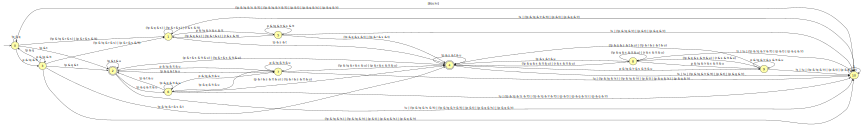

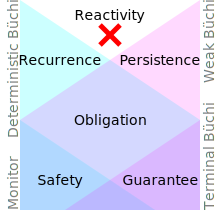

Formula Class: reactivity

 Spot generated accepting trace:
Prefix:
  0
  |  (!p & !q & r & s) | (p & r & s & !t)
  1
  |  !p & s & t
Cycle:
  4
  |  !p & s & t & u	{0}


Automaton States and Edges
  I: I Total Edges Out: 1 Accepting: False Trap: False
	0:  1  
  0: 0 Total Edges Out: 5 Accepting: False Trap: False
	0:  (!p & q)  
	1:  ((((!p & !q) & r) & s) | (((p & r) & s) & !t))  
	2:  (!p & t)  
	3:  ((p & !q) & !t)  
	10:  (((((((!p & !q) & !s) & !t) | (((!p & !q) & !r) & !t)) | (p & t)) | ((p & q) & !s)) | ((p & q) & !r))  
  1: 1 Total Edges Out: 4 Accepting: False Trap: False
	1:  ((((!p & q) & s) | ((!p & r) & s)) | ((r & s) & !t))  
	4:  ((!p & s) & t)  
	5:  ((((p & !q) & !r) & s) & !t)  
	10:  (((!s | (((!p & !q) & !r) & !t)) | (p & t)) | ((p & q) & !r))  
  2: 2 Total Edges Out: 5 Accepting: True Trap: False
	2:  ((!p & t) & u)  
	4:  (((((p & r) & s) & !t) & u) | ((((!q & r) & s) & !t) & u))  
	6:  (((!p & q) & !t) & u)  
	7:  (((p & !q) & !t) & u)  
	10:  (((((!u | (((!p

In [22]:
print(f'{bcolors.ORANGE + bcolors.BOLD}\n---- Spot Converted Formula ----{bcolors.ENDC}')
formula.printSelf()
print(f'{bcolors.ORANGE + bcolors.BOLD}\n---- Original Formula ----{bcolors.ENDC}')
print(f'{formula.formulaStr}')
formula.toLaTeX('Original Formula LaTeX',color=bcolors.ORANGE + bcolors.BOLD)
formula.showGraph(graphPrint,graphFile)
formula.hierarchyMap()
print(f'Formula Class: {formula.fClass()}')
formula.acceptingRun()
# print(type(formula.formula))
#auto.printGraph()

print(f'\nAutomaton States and Edges')
print(auto)
print(f'Predicates:  {auto.predicates}')
print(f'Terminals:   {auto.terminals}')
print(f'Accepting:   {auto.accepting}')
print(f'Traps:       {auto.traps}')
print(f'Start State: {formula.getStartState()}')


---
# Trace Generation

Note: TraceGen attempts to generate all unique traces. This is not always possible if the trace length is short or the automaton is trivial. When printing traces traceAsStr will colorize duplicate traces if colorDups == True.

In [23]:
auto.reset()

print(f'{dLineSeparator}\nGenerating Traces')
print(f'{dLineSeparator}\nRun of Length {runLen}\n')
for run in range(0,numRuns):
    print(f' *** Trace {run} ***')
    auto.genTrace(traceQual=traceQual)
    
print(f'\nTrace Generation Complete\n{dLineSeparator}\n')

auto.printVisitLog()

duplicateCnt = 0
with open(path.joinpath('data.fma1'), 'w') as f:
    f.write(f'{startFormula}\n')
    for trace in (auto.allTraces):
        f.write(f'{trace.traceAsStr()}\n')
        if trace.duplicate == True:
            duplicateCnt += 1
        print(trace.traceAsStr(colorDups=True))

print(f'{dLineSeparator}\nTotal Traces: {len(auto.allTraces)} - {duplicateCnt} Duplicate\n{dLineSeparator}\n')


Generating Traces
Run of Length 10

 *** Trace 0 ***
 *** Trace 1 ***
 *** Trace 2 ***
 *** Trace 3 ***
 *** Trace 4 ***
 *** Trace 5 ***
 *** Trace 6 ***
 *** Trace 7 ***
 *** Trace 8 ***
 *** Trace 9 ***
 *** Trace 10 ***
 *** Trace 11 ***
 *** Trace 12 ***
 *** Trace 13 ***
 *** Trace 14 ***
 *** Trace 15 ***
 *** Trace 16 ***
 *** Trace 17 ***
 *** Trace 18 ***
 *** Trace 19 ***

Trace Generation Complete



,0,1,2,3,4,5,6,7,8,9,10,EdgesCovered,TotalEdges
0,2,6,6,7,-,-,-,-,-,-,2,5,5
1,-,2,-,-,2,6,-,-,-,-,2,4,4
2,-,-,2,-,3,-,3,7,-,-,1,5,5
3,1,1,3,1,1,-,-,-,-,-,1,6,6
4,-,-,-,-,2,-,-,-,3,10,2,4,4
5,-,3,-,-,1,1,-,-,-,-,2,4,4
6,-,-,3,-,1,-,1,1,-,-,1,5,5
7,-,-,2,-,1,-,3,2,-,-,2,5,5
8,-,-,-,-,2,-,-,-,2,1,2,4,4
9,-,-,-,-,6,-,-,-,3,2,2,4,4


!p,t;!p,t,u;!q,r,s,!t,u;!p,s,t,u;p,!q,!r,s,!t,u;!p,r,s,t,u;p,t;1;1;1;
p,r,s,!t;p,t;1;1;1;1;1;1;1;1;
!p,!q,!r,!t;1;1;1;1;1;1;1;1;1;
!p,!q,r,s;!p,r,s;!p,s,t;p,!q,!r,s,!t,u;p,!q,!r,s,!t,u;p,t;1;1;1;1;
p,r,s,!t;!p,s,t;r,s,!t,u;p,q,!r;1;1;1;1;1;1;
p,!q,!t;p,t;1;1;1;1;1;1;1;1;
!p,t;p,r,s,!t,u;!p,q,s,!t,u;!p,s,t,u;p,!q,!r,s,!t,u;r,s,!t,u;!p,q,s,!t,u;p,!q,!r,s,!t,u;!p,q,s,t,u;!p,s,t,u;
p,!q,!t;p,!q,!t;!p,q,t;p,!q,!t,u;p,r,s,!t,u;p,q,!r;1;1;1;1;
p,!q,!t;!p,q,t;p,!q,!t,u;p,q,!r;1;1;1;1;1;1;
p,!q,!t;!p,!q,r,s,t;p,!q,!r,s,!t,u;p,!q,!r,s,!t,u;!p,q,s,!t,u;!p,s,t,u;p,!q,!r,s,!t,u;p,t;1;1;
!p,q;!p,t;p,!q,!t,u;p,!q,!t,u;!p,q,!t,u;!p,t,u;p,q,!s;1;1;1;
p,!q,!t;!p,q,t;p,!q,!t,u;!p,q,!t,u;p,!q,!t,u;!p,q,!t,u;!u;1;1;1;
!p,!q,r,s;p,!q,!r,s,!t;p,t;1;1;1;1;1;1;1;
!p,t;!p,q,!t,u;!p,q,!t,u;!p,t,u;p,!q,!t,u;!p,q,t,u;!p,q,!t,u;!q,r,s,!t,u;p,!q,!r,s,!t,u;!p,q,s,t,u;
p,r,s,!t;p,!q,!r,s,!t;r,s,!t;p,!q,!r,s,!t;!p,q,s,t;p,!q,!r,s,!t,u;!p,r,s,t,u;!p,q,s,!t,u;r,s,!t,u;!u;
p,!q,!t;p,r,s,!t;p,!q,!r,s,!t;p,!q,!r,s,!t;!p,r,s

### Show paths covered by traces  

Green edges are covered edges moving between accepting states or over accepting edges  
Red edges are covered edges moving to trap states  
Black edges are not covered by any trace  

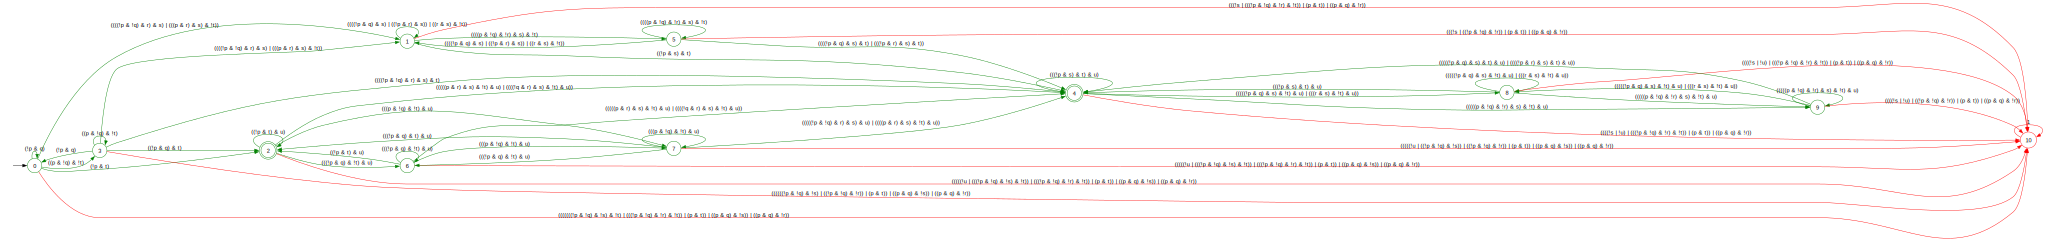

In [24]:
auto.printGraph(traceGraphPrint,traceSource,traceGraphFile)


---
### Different ways to display the traces:

`trace.print() ` has different print options depending on verbose setting (default is verbose=0):
* 0 - Print a simple list of states seen
* 1 - Print the trace through the automaton with state transitions and predicates holding
* 2 - Print a detailed trace evaluation

Setting `color=True` will generate a colorized version of verbose = 0 or 1 where: green indicates state was accepting, red indicates state is a non-accepting trap/sink

Setting `newLine=False` will suppress the line feed after printing the trace. This is usefull for adding additional information to the right of the trace

`title` will print a title on the table when `verbose = 1`

In [25]:
auto.printTraceListHTML(auto.allTraces,title='Automaton Trace Log')
sinkCnt = 0
for i, trace in enumerate(auto.allTraces):
    if trace.sink() == True:
        sinkCnt += 1
print(f'Total traces ending in a sink: {sinkCnt:>3}/{numRuns:<3}\n')

for i, trace in enumerate(auto.allTraces):
    trace.printHTML(verbose=1,color=True,title=f'Trace: {i:3}')

Trace #,1,2,3,4,5,6,7,8,9,10
0,2,2,4,4,9,4,10,10,10,10
1,1,10,10,10,10,10,10,10,10,10
2,10,10,10,10,10,10,10,10,10,10
3,1,1,4,9,9,10,10,10,10,10
4,1,4,8,10,10,10,10,10,10,10
5,3,10,10,10,10,10,10,10,10,10
6,2,4,8,4,9,8,8,9,4,4
7,3,3,2,7,4,10,10,10,10,10
8,3,2,7,10,10,10,10,10,10,10
9,3,4,9,9,8,4,9,10,10,10


Total traces ending in a sink:  17/20 



----
# Test Automaton

This code tests an automaton by reading in a file containing a formula and traces. The traces are applied to the automaton created from the formula and the results are displayed.  

This code requires a file that contains the formula to test in the first row and the traces, one per line on the subsequent rows.  
The file extension is 'fma1'.  

The provided selector shows the fma1 files available in the working directory.

In [26]:
#https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html#Description
testfileExt = 'fma1'
workFiles = []
for file in Path(path).glob(f'*.{testfileExt}'):
    workFiles.append(Path(file).stem)

if len(workFiles) > 0:
    testFile = widgets.Select(
                                options=workFiles,
                                value=workFiles[0],
                                # rows=10,
                                description='Available Files',
                                disabled=False,
                                style={'description_width': 'initial'}
    )
    display(testFile)
else:
    print(f' *** No single formula test files found (.fma1) ***')

Select(description='Available Files', options=('Formula1', 'Formula1LLMa', 'data'), style=DescriptionStyle(des…

In [27]:
print(f'\nGettng formula and traces to test from: {testFile.value}\n')

allTestTraces = []
with open(path.joinpath(f'{testFile.value}.{testfileExt}'), 'r') as f:
    testFormulaStr = f.readline().strip()
    for i,line in enumerate(f):
        trace = Trace.strToTrace(line.strip())
        allTestTraces.append(trace)

testFormula = Formula.setFormula(dOptions,testFormulaStr)
testAuto = buildAutomaton(testFormula)
testFormula.printSelf()

testAuto.allTraces = allTestTraces
testAuto.reset()

for i,trace in enumerate(allTestTraces):
    # print(f'Trace: {i:3}: ')
    testAuto.evaluate(trace,traceQual=traceQual)
    # print(' ')

testAuto.printVisitLog()

testAuto.printTraceListHTML(testAuto.traceLog)
sinkCnt = 0
for i, trace in enumerate(testAuto.traceLog):
    if trace.sink() == True:
        sinkCnt += 1
print(f'Total traces ending in a sink: {sinkCnt:>3}/{numRuns:<3}')

#for i, trace in enumerate(testAuto.traceLog):
#    print(f'\nTrace: {i:3}')
#    testAuto.printTraceLog(trace,verbose=1,color=True)


Gettng formula and traces to test from: Formula1



Generating LALR tables


spot.formula("G((!p | Fq) & (!r | Gs))")

,0,1,2,3,4,EdgesCovered,TotalEdges
0,7,4,2,4,0,4,5
1,-,22,-,21,0,2,3
2,0,1,1,1,0,3,5
3,-,26,-,23,0,2,3
4,-,-,-,-,0,0,1


Trace #,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,3,3,1,3,1,1,3,1,1,-,-,-,-,-,-
1,1,1,3,1,1,3,3,1,1,1,-,-,-,-,-,-
2,0,0,1,1,1,1,3,1,3,1,-,-,-,-,-,-
3,1,3,1,3,1,3,1,1,3,3,1,-,-,-,-,-
4,2,2,1,3,1,3,1,1,3,3,1,-,-,-,-,-
5,0,0,3,1,3,3,1,1,1,3,1,-,-,-,-,-
6,0,0,2,3,3,3,3,3,3,3,1,-,-,-,-,-
7,3,1,3,3,1,1,3,3,3,3,1,-,-,-,-,-
8,3,1,1,1,3,3,1,1,1,3,1,-,-,-,-,-
9,1,3,3,1,1,1,1,1,3,3,3,3,3,3,3,1


Total traces ending in a sink:   0/20 


# Compare Automata

This code compares two automata by running traces from automaton A on automaton B and vis versa  

----

  Start by setting these parameters to define what gets saved and where the formulas come from

In [28]:
compPrint = {'Print'  : True,
             'Source' : False,
             'Stats'  : False 
             }
compFile = {'save'   : False,
             'name'   : path.joinpath('graph'),
             'format' : 'png'}

testFormulasFile = 'CAV_PaperFormulas.csv'
#testFormulasFile = 'compareFormulas.csv'

formulaDir = 'examples'
path = Path(__file__).parent.absolute().joinpath(formulaDir)



Next, select the desired two formulas to compare. The pick box allows multiple selection and you must pick 2.   

Click the first one and then hold down the Command key to select the second

In [29]:
df = pd.read_csv(path.joinpath(testFormulasFile))
nameLen = df.Name.map(lambda x: len(x)).max()
descLen = df.Description.map(lambda x: len(x)).max()
colNames = list(df)

df['combined'] = df[colNames].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

compFormulas = widgets.SelectMultiple(
                            options=df['combined'],
                            value=[df['combined'][0],df['combined'][1]],
                            rows=20,
                            description='Available Formulas (Pick 2)',
                            disabled=False,
                            style={'description_width': 'initial'},
                            layout={'width': 'initial'}
)

print('\nSelect 2 formulas to compare. Hold the Command key down to select the second. Don\'t hit return afterwards, just select next cell and continue running\n')
display(compFormulas)



Select 2 formulas to compare. Hold the Command key down to select the second. Don't hit return afterwards, just select next cell and continue running



SelectMultiple(description='Available Formulas (Pick 2)', index=(0, 1), layout=Layout(width='initial'), option…

In [30]:
if len(compFormulas.index) == 2:
    formula1 = Formula.setFormula(dOptions,df.Formula[compFormulas.index[0]])
    formula2 = Formula.setFormula(dOptions,df.Formula[compFormulas.index[1]])
    auto1 = buildAutomaton(formula1)
    auto2 = buildAutomaton(formula2)
else:
    print(f'  *** Insufficient formulas selected (Pick 2) ***')

Generating LALR tables
Generating LALR tables



---- Original Formula ----


spot.formula("G((!p | Fq) & (!r | Gs))")

G((p -> F(q))&(r->G(s)))

---- Original Formula LaTeX ----
G((p \limplies F(q))\land (r\limpliesG(s)))

------------------------------


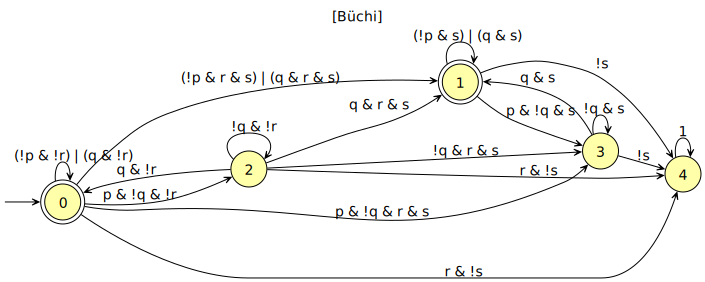

Formula Class: recurrence reactivity

States and Edges
Predicates:  ['p', 'q', 'r', 's']
Terminals:   ['4']
Accepting:   ['0', '1']
Traps:       ['4']
Start State: 0

---- Comparison Formula ----


spot.formula("G(!p | X(Fq & (!r | XGs)))")

G(p -> X(F(q) & (r -> X(G(s)))))

---- Comparison Formula LaTeX ----
G(p \limplies X(F(q) \land  (r \limplies X(G(s)))))

------------------------------


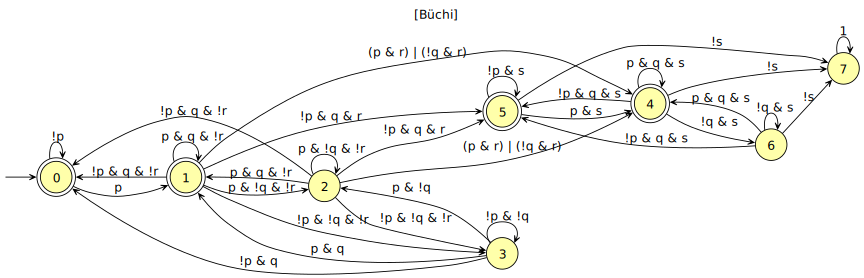

Formula Class: recurrence reactivity

States and Edges
Predicates:  ['p', 'q', 'r', 's']
Terminals:   ['7']
Accepting:   ['0', '1', '4', '5']
Traps:       ['7']
Start State: 0


In [31]:
print(f'{bcolors.ORANGE + bcolors.BOLD}\n---- Original Formula ----{bcolors.ENDC}')
formula1.printSelf()
print(f'{formula1.formulaStr}')
formula1.toLaTeX('Original Formula LaTeX',color=bcolors.ORANGE + bcolors.BOLD)
formula1.showGraph(compPrint,compFile)
print(f'Formula Class: {formula1.fClass()}')

print(f'\nStates and Edges')
print(f'Predicates:  {auto1.predicates}')
print(f'Terminals:   {auto1.terminals}')
print(f'Accepting:   {auto1.accepting}')
print(f'Traps:       {auto1.traps}')
print(f'Start State: {formula1.getStartState()}')

print(f'{bcolors.ORANGE + bcolors.BOLD}\n---- Comparison Formula ----{bcolors.ENDC}')
formula2.printSelf()
print(f'{formula2.formulaStr}')
formula2.toLaTeX('Comparison Formula LaTeX',color=bcolors.ORANGE + bcolors.BOLD)
formula2.showGraph(compPrint,compFile)
print(f'Formula Class: {formula2.fClass()}')

print(f'\nStates and Edges')
print(f'Predicates:  {auto2.predicates}')
print(f'Terminals:   {auto2.terminals}')
print(f'Accepting:   {auto2.accepting}')
print(f'Traps:       {auto2.traps}')
print(f'Start State: {formula2.getStartState()}')


### Generate a batch of traces for each automaton


In [32]:
traceQual='Any'

auto1.reset(resetLog=True)
auto2.reset(resetLog=True)
for run in range(0,numRuns):
    auto1.genTrace(tracePrint=False,traceQual=traceQual)
    auto2.genTrace(tracePrint=False,traceQual=traceQual)
    
auto1.printVisitLog(title=f'Automaton 1 Traces:')
for trace in (auto1.allTraces):
    print(trace.traceAsStr(colorDups=True))

print('')
auto2.printVisitLog(title=f'Automaton 2 Traces:')
for trace in (auto2.allTraces):
    print(trace.traceAsStr(colorDups=True))

testTraces = auto1.allTraces

,0,1,2,3,4,EdgesCovered,TotalEdges
0,4,4,14,3,4,5,5
1,-,6,-,13,5,3,3
2,5,3,3,3,3,5,5
3,-,13,-,6,6,3,3
4,-,-,-,-,105,1,1


q,!r;p,!q,!r;!q,r,s;!q,s;q,s;p,!q,s;q,s;!p,s;p,!q,s;q,s;
p,!q,r,s;!s;1;1;1;1;1;1;1;1;
p,!q,!r;r,!s;1;1;1;1;1;1;1;1;
p,!q,r,s;q,s;!s;1;1;1;1;1;1;1;
r,!s;1;1;1;1;1;1;1;1;1;
!p,r,s;q,s;p,!q,s;q,s;!s;1;1;1;1;1;
p,!q,!r;q,!r;p,!q,!r;!q,!r;q,r,s;p,!q,s;!s;1;1;1;
q,!r;p,!q,r,s;!q,s;q,s;q,s;p,!q,s;!q,s;q,s;!s;1;
r,!s;1;1;1;1;1;1;1;1;1;
p,!q,!r;q,!r;p,!q,!r;q,!r;p,!q,!r;q,r,s;p,!q,s;!s;1;1;
q,r,s;q,s;p,!q,s;q,s;p,!q,s;!s;1;1;1;1;
p,!q,!r;r,!s;1;1;1;1;1;1;1;1;
p,!q,!r;!q,!r;!q,r,s;!q,s;q,s;!s;1;1;1;1;
q,!r;p,!q,!r;q,!r;r,!s;1;1;1;1;1;1;
!p,r,s;q,s;!s;1;1;1;1;1;1;1;
p,!q,!r;q,r,s;p,!q,s;q,s;p,!q,s;!s;1;1;1;1;
p,!q,!r;!q,r,s;!q,s;q,s;!p,s;p,!q,s;!q,s;q,s;p,!q,s;q,s;
p,!q,!r;!q,!r;r,!s;1;1;1;1;1;1;1;
!p,!r;p,!q,!r;q,!r;r,!s;1;1;1;1;1;1;
!p,r,s;p,!q,s;!s;1;1;1;1;1;1;1;



,0,1,2,3,4,5,6,7,EdgesCovered,TotalEdges
0,3,32,-,-,-,-,-,-,2,2
1,3,3,12,16,7,4,-,-,6,6
2,4,5,2,2,2,2,-,-,6,6
3,6,6,4,3,-,-,-,-,4,4
4,-,-,-,-,3,5,9,3,4,4
5,-,-,-,-,9,2,-,3,3,3
6,-,-,-,-,2,3,2,2,4,4
7,-,-,-,-,-,-,-,41,1,1


!p;p;p,r;!q,s;!q,s;!p,q,s;p,s;!q,s;!p,q,s;!p,s;
p;!p,q,!r;p;p,!q,!r;p,q,!r;!p,!q,!r;!p,q;p;!p,!q,!r;!p,!q;
p;!p,q,r;!s;1;1;1;1;1;1;1;
p;!p,q,r;p,s;!s;1;1;1;1;1;1;
p;!p,q,r;p,s;!q,s;!p,q,s;p,s;!p,q,s;p,s;!q,s;p,q,s;
p;!p,!q,!r;p,q;!p,!q,!r;p,q;p,!q,!r;p,q,!r;p,q,!r;!q,r;!q,s;
p;!p,!q,!r;p,q;!q,r;p,q,s;!q,s;!s;1;1;1;
p;!p,!q,!r;p,q;!p,!q,!r;p,q;p,!q,!r;!p,!q,!r;p,!q;p,!q,!r;p,r;
p;!p,!q,!r;!p,q;p;p,!q,!r;!p,q,!r;p;p,!q,!r;!p,q,r;p,s;
!p;p;!p,q,!r;p;!q,r;p,q,s;!q,s;p,q,s;!p,q,s;!p,s;
p;p,!q,!r;!p,q,!r;p;p,!q,!r;!p,q,r;p,s;!p,q,s;p,s;!q,s;
p;!p,!q,!r;!p,q;p;p,r;!p,q,s;!s;1;1;1;
p;p,r;!s;1;1;1;1;1;1;1;
p;p,r;!q,s;!q,s;!s;1;1;1;1;1;
p;p,q,!r;p,!q,!r;p,q,!r;p,!q,!r;p,q,!r;!p,!q,!r;p,!q;p,!q,!r;!p,!q,!r;
p;p,!q,!r;!q,r;p,q,s;!s;1;1;1;1;1;
p;p,!q,!r;p,q,!r;p,!q,!r;!p,q,!r;p;!p,!q,!r;!p,!q;!p,q;!p;
p;!p,q,!r;p;!p,!q,!r;!p,!q;!p,q;p;!p,!q,!r;!p,q;p;
p;!p,!q,!r;p,!q;!p,q,!r;p;!p,!q,!r;p,q;p,q,!r;!p,!q,!r;p,!q;
p;!p,q,r;p,s;!p,q,s;!s;1;1;1;1;1;


### Run traces generated from the original formula on both the original formula and the candidate formula   

Show how well the two compare in accepting the traces.

In [33]:
auto1.reset(resetLog=True)
auto2.reset(resetLog=True)

print(f'Traces Used In Comparison')
for i,trace in enumerate(testTraces):
    print(f'{i:3} {trace.traceAsStr(colorDups=True)}')
print()

for i, trace in enumerate(testTraces):
    errMsg = auto1.evaluate(trace,traceQual=traceQual)
    if len(errMsg) > 0:
        print(f'{errMsg}')

auto1.printTraceListHTML(auto1.traceLog,title=f'Automaton 1 Evaluation')

for i, trace in enumerate(testTraces):
    errMsg = auto2.evaluate(trace,traceQual=traceQual)
    if len(errMsg) > 0:
        print(f'{errMsg}')

auto2.printTraceListHTML(auto2.traceLog,title=f'Automaton 2 Evaluation')


Traces Used In Comparison
  0 q,!r;p,!q,!r;!q,r,s;!q,s;q,s;p,!q,s;q,s;!p,s;p,!q,s;q,s;
  1 p,!q,r,s;!s;1;1;1;1;1;1;1;1;
  2 p,!q,!r;r,!s;1;1;1;1;1;1;1;1;
  3 p,!q,r,s;q,s;!s;1;1;1;1;1;1;1;
  4 r,!s;1;1;1;1;1;1;1;1;1;
  5 !p,r,s;q,s;p,!q,s;q,s;!s;1;1;1;1;1;
  6 p,!q,!r;q,!r;p,!q,!r;!q,!r;q,r,s;p,!q,s;!s;1;1;1;
  7 q,!r;p,!q,r,s;!q,s;q,s;q,s;p,!q,s;!q,s;q,s;!s;1;
  8 r,!s;1;1;1;1;1;1;1;1;1;
  9 p,!q,!r;q,!r;p,!q,!r;q,!r;p,!q,!r;q,r,s;p,!q,s;!s;1;1;
 10 q,r,s;q,s;p,!q,s;q,s;p,!q,s;!s;1;1;1;1;
 11 p,!q,!r;r,!s;1;1;1;1;1;1;1;1;
 12 p,!q,!r;!q,!r;!q,r,s;!q,s;q,s;!s;1;1;1;1;
 13 q,!r;p,!q,!r;q,!r;r,!s;1;1;1;1;1;1;
 14 !p,r,s;q,s;!s;1;1;1;1;1;1;1;
 15 p,!q,!r;q,r,s;p,!q,s;q,s;p,!q,s;!s;1;1;1;1;
 16 p,!q,!r;!q,r,s;!q,s;q,s;!p,s;p,!q,s;!q,s;q,s;p,!q,s;q,s;
 17 p,!q,!r;!q,!r;r,!s;1;1;1;1;1;1;1;
 18 !p,!r;p,!q,!r;q,!r;r,!s;1;1;1;1;1;1;
 19 !p,r,s;p,!q,s;!s;1;1;1;1;1;1;1;



Trace #,1,2,3,4,5,6,7,8,9,10
0,0,2,3,3,1,3,1,1,3,1
1,3,4,4,4,4,4,4,4,4,4
2,2,4,4,4,4,4,4,4,4,4
3,3,1,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
5,1,1,3,1,4,4,4,4,4,4
6,2,0,2,2,1,3,4,4,4,4
7,0,3,3,1,1,3,3,1,4,4
8,4,4,4,4,4,4,4,4,4,4
9,2,0,2,0,2,1,3,4,4,4


Trace #,1,2,3,4,5,6,7,8,9,10
0,0,1,4,6,5,4,4,5,4,4
1,1,2,0,0,0,1,0,1,3,1
2,1,4,7,7,7,7,7,7,7,7
3,1,5,7,7,7,7,7,7,7,7
4,1,4,5,5,4,6,4,7,7,7
5,0,0,1,1,3,0,1,0,1,5
6,1,1,2,3,0,1,4,7,7,7
7,1,4,6,4,4,6,6,5,7,7
8,0,0,1,2,4,7,7,7,7,7
9,1,0,1,0,1,5,4,7,7,7


#### Print a coverage map for both formulas

,0,1,2,3,4,EdgesCovered,TotalEdges
0,4,4,14,3,4,5,5
1,-,6,-,13,5,3,3
2,5,3,3,3,3,5,5
3,-,13,-,6,6,3,3
4,-,-,-,-,105,1,1


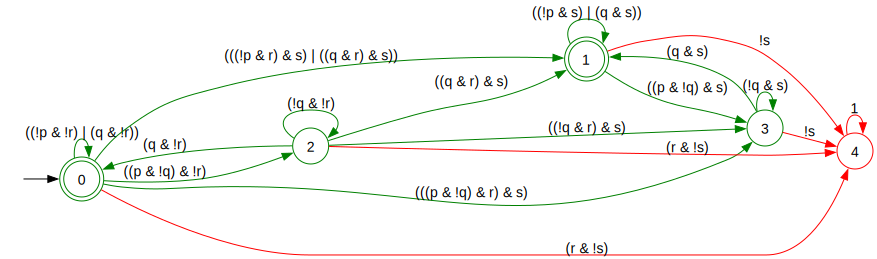

,0,1,2,3,4,5,6,7,EdgesCovered,TotalEdges
0,15,28,-,-,-,-,-,-,2,2
1,4,5,4,5,11,5,-,-,6,6
2,2,0,1,2,2,0,-,-,4,6
3,3,2,2,2,-,-,-,-,4,4
4,-,-,-,-,7,4,11,11,4,4
5,-,-,-,-,9,2,-,2,3,3
6,-,-,-,-,5,4,2,2,4,4
7,-,-,-,-,-,-,-,48,1,1


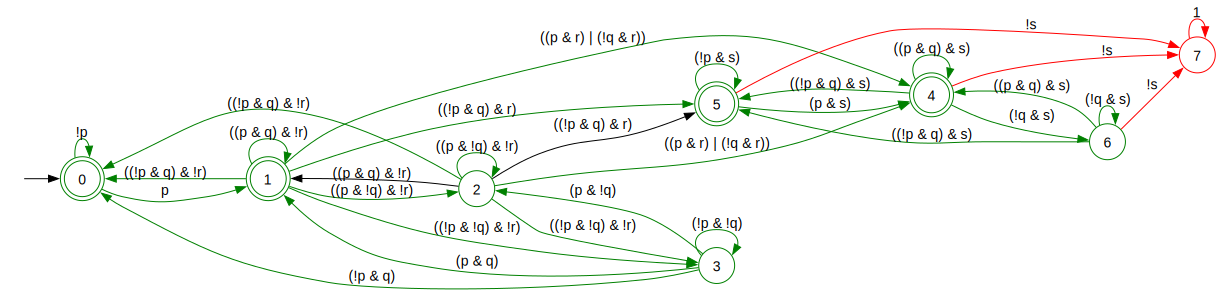

In [34]:
auto1.printVisitLog(title=f'Automaton 1 Traces:')
auto1.printGraph(traceGraphPrint,traceSource,traceGraphFile)

auto2.printVisitLog(title=f'Automaton 2 Walk Using Automaton 1 Traces:')
auto2.printGraph(traceGraphPrint,traceSource,traceGraphFile)


---
### Test Code to show how to read a trace forwards and backwards

In [35]:
print(f'Forwards')
trace = testTraces[0]
trace.start()
done = False
while done != True:
    step = trace.next()
    if step == None:
        done = True
    else:
        print(step)

Forwards
0   -> 0  : [] ['q', '!r']
0   -> 2  : [] ['p', '!q', '!r']
2   -> 3  : [] ['!q', 'r', 's']
3   -> 3  : [] ['!q', 's']
3   -> 1  : [] ['q', 's']
1   -> 3  : [] ['p', '!q', 's']
3   -> 1  : [] ['q', 's']
1   -> 1  : [] ['!p', 's']
1   -> 3  : [] ['p', '!q', 's']
3   -> 1  : [] ['q', 's']


In [36]:
print(f'Backwards')
done = False
while done != True:
    step = trace.back()
    if step == None:
        done = True
    else:
        print(step)

Backwards
3   -> 1  : [] ['q', 's']
1   -> 3  : [] ['p', '!q', 's']
1   -> 1  : [] ['!p', 's']
3   -> 1  : [] ['q', 's']
1   -> 3  : [] ['p', '!q', 's']
3   -> 1  : [] ['q', 's']
3   -> 3  : [] ['!q', 's']
2   -> 3  : [] ['!q', 'r', 's']
0   -> 2  : [] ['p', '!q', '!r']
0   -> 0  : [] ['q', '!r']


---
### Example code showing how to evaluate a trace

Using the comparison automaton from above, take a trace from automaton 1 and evaluate it on automaton 2.   

Note: Derived predicates are program generated from the don't care predicates at that step in order to continue moving. If there is no valid predicate combination to satisfy any edge, the evaluation stops at this step.

In [37]:
allowedStates = auto2.allStates
curState = '0'
traceLog = []
testTrace = testTraces[1]
testTrace.start()

trace, errMsg = auto2.states[curState].evaluate(allowedStates,testTrace,Trace())
traceLog.append(trace)
print(errMsg)

for trace in traceLog:
    trace.printHTML(verbose=1,color=True)


---
### Example code to create an equation data structure

In [38]:
xx = AndNode(AndNode(Predicate('d'),Predicate('e')),OrNode(AndNode(Predicate('a'),Predicate('b')),AndNode(UniNode('!',Predicate('a')),Predicate('c'))))
#xx = OrNode(AndNode(Predicate('a'),Predicate('b')),OrNode(UniNode('!',Predicate('a')),Predicate('c')))
print(xx)
print(xx.satisfiers())

((d & e) & ((a & b) | (!a & c)))
[['d', 'e', 'a', 'b'], ['d', 'e', '!a', 'c']]


---
### Scratchpad area for trying various Python algorithms

In [39]:
a = ['r', 'g', '!y']
b = ['y', 'r']
c = ['r', 'y']
d = [a[i].replace('!','') for i in range(len(a))]
print(f'{d}')
print(set(a).intersection(b))
print(set(b).intersection(a))
print(set(b) - set(a))
print(set(a).intersection(c) == set(a))
print(set(d).intersection(c) == set(d))
print(set(b).intersection(c) == set(b))

['r', 'g', 'y']
{'r'}
{'r'}
{'y'}
False
False
True


In [40]:
a = [['a'],['r', 'g', '!y'],['a','b']]
b = [['y','r']]
c = [['a','b'],['c','d']]
d = [['z']]
all = []
for aa in b:
    for bb in d:
        print(f'{aa} {bb}')
        all.append(aa+bb)
print(all)
print(a)
print(b)
print(c)


['y', 'r'] ['z']
[['y', 'r', 'z']]
[['a'], ['r', 'g', '!y'], ['a', 'b']]
[['y', 'r']]
[['a', 'b'], ['c', 'd']]


In [41]:
a = {'a', 'b'}
b = set()
print(len(a),type(a), a)
print(len(b),type(b), b)
c = list(b)
print(c)

2 <class 'set'> {'b', 'a'}
0 <class 'set'> set()
[]


<table>
<thead>
<tr><th>item
name      </th><th style="text-align: right;">  qty</th></tr>
</thead>
<tbody>
<tr><td>spam </td><td style="text-align: right;">   42</td></tr>
<tr><td>eggs </td><td style="text-align: right;">  451</td></tr>
<tr><td>bacon</td><td style="text-align: right;">    0</td></tr>
</tbody>
</table>

<TABLE bgcolor="black">
    <TR>
    <TD color="green" bgcolor="green">00</TD>
    <TD color="green" bgcolor="green">01</TD>
    </TR>
    <TR>
    <TD color="green" bgcolor="green">10</TD>
    <TD color="green" bgcolor="green">11</TD>
    </TR>
    </TABLE>

In [42]:
self = auto2
allStates = list(self.states.keys())
if 'I' in allStates:
    allStates.remove('I')
title = 'A Table'

caption = f'<caption>{title}</caption>\n' if len(title) > 0 else ''
tblTitle = '<caption style="background-color:DodgerBlue;"><b>From State To State Visit Count</b></caption>\n'
xLabel = '<caption style="background-color:DodgerBlue;">To State</caption>\n'
head = '<thead style="background-color:DodgerBlue;"> \n\t<tr><th> </th>'
body = '<tbody>\n'
for i in allStates:
    row = f'\t<tr><td>{i}</td>'
    head += f'\n\t<th width=20em>{i}</th>'
    for s in allStates:
        row += f'<td>{self.states[i].statesSeen.get(s,"-")}</td>'
    row += f'<td style="text-align:center;">{self.states[i].edgesVisited()}</td>'
    row += f'<td style="text-align:center;">{self.states[i].edgesTotal()}</td>'
    row += '</tr>\n'
    body += row

body += '</tbody>\n'
head += '\n\t<th width=15em style="text-align:center">Edges<br>Covered</th>\n\t<th width=15em style="text-align:center">Total<br>Edges</th></tr>\n</thead>\n'
table = ''.join(['<table style="border:2px solid DodgerBlue;">\n',caption,tblTitle,xLabel,head,body,'</table>'])
display(HTML(table))

print(table)


,0,1,2,3,4,5,6,7,EdgesCovered,TotalEdges
0,16,30,-,-,-,-,-,-,2,2
1,5,5,4,5,12,5,-,-,6,6
2,2,0,1,2,2,0,-,-,4,6
3,3,2,2,2,-,-,-,-,4,4
4,-,-,-,-,7,4,11,12,4,4
5,-,-,-,-,9,2,-,2,3,3
6,-,-,-,-,5,4,2,2,4,4
7,-,-,-,-,-,-,-,52,1,1


<table style="border:2px solid DodgerBlue;">
<caption>A Table</caption>
<caption style="background-color:DodgerBlue;"><b>From State To State Visit Count</b></caption>
<caption style="background-color:DodgerBlue;">To State</caption>
<thead style="background-color:DodgerBlue;"> 
	<tr><th> </th>
	<th width=20em>0</th>
	<th width=20em>1</th>
	<th width=20em>2</th>
	<th width=20em>3</th>
	<th width=20em>4</th>
	<th width=20em>5</th>
	<th width=20em>6</th>
	<th width=20em>7</th>
	<th width=15em style="text-align:center">Edges<br>Covered</th>
	<th width=15em style="text-align:center">Total<br>Edges</th></tr>
</thead>
<tbody>
	<tr><td>0</td><td>16</td><td>30</td><td>-</td><td>-</td><td>-</td><td>-</td><td>-</td><td>-</td><td style="text-align:center;">2</td><td style="text-align:center;">2</td></tr>
	<tr><td>1</td><td>5</td><td>5</td><td>4</td><td>5</td><td>12</td><td>5</td><td>-</td><td>-</td><td style="text-align:center;">6</td><td style="text-align:center;">6</td></tr>
	<tr><td>2</td><td>2<

In [43]:
allowedStates = auto2.allStates
curState = '0'
traceLog = []
testTrace = testTraces[1]
testTrace.start()

self, errMsg = auto2.states[curState].evaluate(allowedStates,testTrace,Trace())
color = True
title = 'Test Table'

self.start()
step = self.next()

caption = f'<caption>{title}</caption>\n' if len(title) > 0 else ''
head1 = '\n\t<tr ><th colspan="3"> </th><th colspan="2" style="text-align:center;">Predicates</th></tr>'
head2 = '\n\t<tr><th>s</th><th>&#10142;</th><th>s\'</th><th style="text-align:center;">Derived</th></th><th style="text-align:center;">Given</th></tr>'
head = ''.join(['<thead style="background-color:DodgerBlue;">',head1,head2])

body = '<tbody>\n'

while step != None:
    styleTo = ''
    styleFrom = ''
    if color == True:
        if step.fromState.accepting == True:
            styleFrom = f'style="background-color:DarkGreen;"'
        elif step.fromState.trap == True:
            styleFrom = f'style="background-color:DarkRed;"'
            
        if step.toState.accepting == True:
            styleTo = f'style="background-color:DarkGreen;"'
        elif step.toState.trap == True:
            styleTo = f'style="background-color:DarkRed;"'
    row = f'\t<tr><td {styleFrom}>{step.fromState.stateNum}</td><td>&#10142;</td><td {styleTo}>{step.toState.stateNum}</td>'

    preds = ''
    for i, pred in enumerate(step.extraPreds):
        if i > 0:
            preds += ', '
        preds += pred
    row += f'<td style="text-align:center;">{preds}</td>'

    preds = ''
    for i, pred in enumerate(step.predicates):
        if i > 0:
            preds += ', '
        preds += pred
    row += f'<td style="text-align:center;">{preds}</td>'

    row += '</tr>\n'
    body += row
    step = self.next()

body += '</tbody>\n'
head += '\n</thead>\n'
table = ''.join(['<table style="border:2px solid DodgerBlue;">\n',caption,head,body,'</table>'])
display(HTML(table))

print(table)


<table style="border:2px solid DodgerBlue;">
<caption>Test Table</caption>
<thead style="background-color:DodgerBlue;">
	<tr ><th colspan="3"> </th><th colspan="2" style="text-align:center;">Predicates</th></tr>
	<tr><th>s</th><th>&#10142;</th><th>s'</th><th style="text-align:center;">Derived</th></th><th style="text-align:center;">Given</th></tr>
</thead>
<tbody>
	<tr><td style="background-color:DarkGreen;">0</td><td>&#10142;</td><td style="background-color:DarkGreen;">1</td><td style="text-align:center;"></td><td style="text-align:center;">p, !q, r, s</td></tr>
	<tr><td style="background-color:DarkGreen;">1</td><td>&#10142;</td><td style="background-color:DarkGreen;">0</td><td style="text-align:center;">!p, q, !r</td><td style="text-align:center;">!s</td></tr>
	<tr><td style="background-color:DarkGreen;">0</td><td>&#10142;</td><td style="background-color:DarkGreen;">0</td><td style="text-align:center;">!p</td><td style="text-align:center;">1</td></tr>
	<tr><td style="background-color

In [44]:
# Build the lexer
lexer = DotLexer()
lexer.build()
g = formula.formulaDot

# Give the lexer some input
lexer.test(g)
print(g)

LexToken(DIGRAPH,'digraph',1,0)
LexToken(STRING,'""',1,8)
LexToken({,'{',1,11)
LexToken(RANKDIR,'rankdir',1,15)
LexToken(=,'=',1,22)
LexToken(ID,'LR',1,23)
LexToken(LABEL,'label',1,28)
LexToken(=,'=',1,33)
LexToken(HTMLSTRING,'<[Büchi]>',1,34)
LexToken(LABELLOC,'labelloc',1,46)
LexToken(=,'=',1,54)
LexToken(STRING,'"t"',1,55)
LexToken(NODESTYLE,'node',1,61)
LexToken([,'[',1,66)
LexToken(SHAPE,'shape',1,67)
LexToken(=,'=',1,72)
LexToken(STRING,'"ellipse",width="0.5",height="0.5"',1,73)
LexToken(],']',1,107)
LexToken(NODESTYLE,'node',1,111)
LexToken([,'[',1,116)
LexToken(STYLE,'style',1,117)
LexToken(=,'=',1,122)
LexToken(STRING,'"filled", fillcolor="#ffffaa"',1,123)
LexToken(],']',1,152)
LexToken(FONTNAME,'fontname',1,156)
LexToken(=,'=',1,164)
LexToken(STRING,'"Lato"',1,165)
LexToken(NODESTYLE,'node',1,174)
LexToken([,'[',1,179)
LexToken(FONTNAME,'fontname',1,180)
LexToken(=,'=',1,188)
LexToken(STRING,'"Lato"',1,189)
LexToken(],']',1,195)
LexToken(EDGESTYLE,'edge',1,199)
LexToken([,'['